<a href="https://colab.research.google.com/github/achett/Hierarchical-Model/blob/main/Volume_FY23_Blind_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install hierarchicalforecast
# !pip install statsforecast
# !pip install datasetsforecast
# !pip install nixtlats>=0.1.0
# !pip install darts
# !pip install mlforecast

In [ ]:
########################
# PACKAGES
########################
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl
from datetime import datetime
from functools import reduce
from dateutil.relativedelta import relativedelta

from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from itertools import product
import ast


pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
##############
# PARAMS
##############
fct_periods = 15
fct_st_date = '2023-04-01'
fct_end_date = '2024-03-01'

# Create hierarchical structure and constraints
hierarchy_levels = [['TopLv'],
                    ['TopLv', 'ProductLv'],
                    ['TopLv', 'ProductLv', 'Lv1'],
                    ['TopLv', 'ProductLv', 'Lv1', 'Lv2'],
                    ['TopLv', 'ProductLv', 'Lv1', 'Lv2', 'Lv3'],
                    ['TopLv', 'ProductLv', 'Lv1', 'Lv2', 'Lv3', 'Lv4'],
                    ['TopLv', 'ProductLv', 'Lv1', 'Lv2', 'Lv3', 'Lv4', 'Lv5']]

inputFile = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/regional_hierarchy.xlsx'
sheet_name = 'regional_hierarchy v2'
r_hier = pd.read_excel(inputFile, sheet_name=sheet_name)

inputFile = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/model_selection.xlsx'
model_selection = pd.read_excel(inputFile)

inputFile = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/Product Naming Convention.xlsx'
product_naming_convention = pd.read_excel(inputFile)

In [ ]:
##############
# FUNCTIONS
##############
def prepare_data(data, r_hier):

    # Merge hierarchy
    data = data.merge(r_hier, how='inner', left_on='cost_object', right_on='Lv5')

    # Transform date and y
    data['ds'] = pd.to_datetime(data['ds'])
    data['y'] = data['y'].astype(float)

    # Address NA values
    data['y'] = data['y'].fillna(0)
    data['TopLv'] = data['TopLv'].fillna('')
    data['Lv1'] = data['Lv1'].fillna('')
    data['Lv2'] = data['Lv2'].fillna('')
    data['Lv3'] = data['Lv3'].fillna('')
    data['Lv4'] = data['Lv4'].fillna('')
    data['Lv5'] = data['Lv5'].fillna('')
    data['product'] = data['product'].fillna('')

    # Create hierarchical dataframe
    data.rename(columns={'product': 'ProductLv'}, inplace=True)
    data = data[['TopLv', 'ProductLv', 'Lv1', 'Lv2', 'Lv3', 'Lv4', 'Lv5', 'ds', 'y']]

    # Replace '/' with '_' in the four columns
    data['TopLv'] = data['TopLv'].str.replace('/', '_')
    data['ProductLv'] = data['ProductLv'].str.replace('/', '_')
    data['Lv1'] = data['Lv1'].str.replace('/', '_')
    data['Lv2'] = data['Lv2'].str.replace('/', '_')
    data['Lv3'] = data['Lv3'].str.replace('/', '_')
    data['Lv4'] = data['Lv4'].str.replace('/', '_')
    data['Lv5'] = data['Lv5'].str.replace('/', '_')

    data['unique_id'] = data['TopLv'] + '/' + data['ProductLv'] + '/' + data['Lv1'] + '/' + data['Lv2'] + '/' + data['Lv3'] + '/' + data['Lv4'] + '/' + data['Lv5']

    # Assuming df is your existing DataFrame
    grouping_columns = ['TopLv', 'ProductLv', 'Lv1', 'Lv2', 'Lv3', 'Lv4', 'Lv5', 'ds', 'unique_id']  # All columns except 'y'

    # Group by specified columns and sum 'y'
    data = data.groupby(grouping_columns)['y'].sum().reset_index()

    return data

def prepare_feature(data, r_hier, volume_act2, feature_name):

    # Select and rename columns
    data = data[['cost_object', 'product', 'ds', feature_name]].rename(columns={feature_name: 'y'})

    # Apply any additional preparation (assuming prepare_data is a function you have defined)
    data = prepare_data(data, r_hier)

    # Rename the columns back
    data = data.rename(columns={'y': feature_name})

    # Merge with the volume_act2 dataframe
    merged_df = data.merge(volume_act2[['unique_id', 'ds']], how='right', on=['unique_id', 'ds'])

    return merged_df


In [ ]:
##############
# DATA LOAD
##############
# inputFile_dx = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/revenue_output.csv'
# inputFile_bud = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/budgetFY23.csv'
# inputFile_ms = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/unrestricted_model_settings.csv'

inputFile_dx = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/volume_output.csv'
inputFile_bud = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/budgetFY23 Volume.csv'
inputFile_ms = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/unrestricted_model_settings_volume.csv'


budget = pd.read_csv(inputFile_bud)
budget.rename(columns={'country': 'cost_object'}, inplace=True)
budget = prepare_data(budget, r_hier)

volume_act = pd.read_csv(inputFile_dx)
volume_act.rename(columns={'value': 'y'}, inplace=True)
volume_act = prepare_data(volume_act, r_hier)

inputFile = '/content/drive/MyDrive/Colab Notebooks/SGA Prediction/data/sga_output.csv'
sga = pd.read_csv(inputFile)

sga1 = prepare_feature(sga, r_hier, volume_act, 'AP')
sga2 = prepare_feature(sga, r_hier, volume_act, 'Field_Sales')
sga3 = prepare_feature(sga, r_hier, volume_act, 'Smoothed_AP')
sga4 = prepare_feature(sga, r_hier, volume_act, 'Smoothed_Field_Sales')

sga1 = sga1[['unique_id', 'ProductLv', 'Lv5', 'ds', 'AP']]
sga1 = sga1.dropna(subset=['ProductLv'])
sga1['ID'] = sga1['ProductLv']+sga1['Lv5']

sga2 = sga2[['unique_id', 'ProductLv', 'Lv5', 'ds', 'Field_Sales']]
sga2 = sga2.dropna(subset=['ProductLv'])
sga2['ID'] = sga2['ProductLv']+sga2['Lv5']

In [ ]:
########################
# IDENTIFY UNIVERSE
########################
tested_ts = set(budget['unique_id'].unique()).intersection(volume_act['unique_id'].unique())

# Find unique IDs present in budget_h but not in rev
unique_ids_in_budget_not_in_rev = set(budget['unique_id'].unique()).difference(volume_act['unique_id'].unique())

# Find unique IDs present in rev but not in budget_h
unique_ids_in_rev_not_in_budget = set(volume_act['unique_id'].unique()).difference(budget['unique_id'].unique())

# Filter volume
volume_act = volume_act[volume_act['unique_id'].isin(tested_ts)]

In [ ]:
########################
# SEGMENT TIME SERIES
########################
new_products = ['ENFORTUMAB - Enforumab Vedotin', 'ROXADUSTNT - Roxadustant']
loe_products = ['REGADENOSN - Regadenoson']
div_products = ['MICAFUNGIN - Micafungin Sodium']

new_ids = volume_act[volume_act['ProductLv'].isin(new_products)]['unique_id'].unique().tolist()
loe_ids = volume_act[volume_act['ProductLv'].isin(loe_products)]['unique_id'].unique().tolist()
divested_ids = volume_act[volume_act['ProductLv'].isin(div_products)]['unique_id'].unique().tolist()

# IDs with A&P and Field Sales Spend
grouped1 = sga1.groupby('unique_id')[['AP']].sum()
grouped2 = sga2.groupby('unique_id')[['Field_Sales']].sum()
spend_ids = set(grouped1[(grouped1['AP'] > 0)].index.tolist() + grouped2[(grouped2['Field_Sales'] > 0)].index.tolist())
spend_ids = spend_ids.difference(new_ids + loe_ids + divested_ids)

# IDs with no spend
non_spend_ids = volume_act[~volume_act['unique_id'].isin(spend_ids)]['unique_id'].unique()

In [ ]:
########################
# DATA CONVERSION
########################
set2zero_list=['Global/TAMSULOSIN - Tamsulosin HCl/D_GCN - Greater China/D_CN_TOTAL - China Total/D_CN_TOTAL - China Total/D_CN_TOTAL - China Total/D_CN_TOTAL - China Total',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_BENELUX - Benelux/D_E_BELGIUM - Belgium/D_E_BELGIUM - Belgium',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_BBMCI - BBMCI group/D_E_BALKANS - Balkans/D_E_BOS_HER - Bosnia-Herz.',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_BBMCI - BBMCI group/D_E_BALKANS - Balkans/D_E_BOS_HER - Bosnia-Herz.',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_ADRCS_PT - Adriatics & Portugal/D_E_ADRCS - Adriatic Adriatics/D_E_CROATIA - Croatia',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_ADRCS_PT - Adriatics & Portugal/D_E_ADRCS - Adriatic Adriatics/D_E_CROATIA - Croatia',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_PCSU - PCSU/D_E_CZSK - Czech + Slovakia/D_E_CZECH - Czech',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_FRANCE - France/D_E_FRANCE - France/D_E_FRANCE - France/D_E_FRANCE - France',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_FRANCE - France/D_E_FRANCE - France/D_E_FRANCE - France/D_E_FRANCE - France',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_GB - Great Britain/D_E_GB - Great Britain/D_E_GB - Great Britain/D_E_GB - Great Britain',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_HUBGROGR - HBRG/D_E_HUBGRO - Hungary  Bulgaria & Romania/D_E_HU - Hungary',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_IE - Ireland/D_E_IE - Ireland/D_E_IE - Ireland',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_IT - Italy/D_E_IT - Italy/D_E_IT - Italy/D_E_IT - Italy',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_BBMCI - BBMCI group/D_E_MTCYIS - Malta  Cyprus & Iceland/D_E_MALTA - Malta',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_NORDIC - Nordic/D_E_NORWAY - Norway/D_E_NORWAY - Norway',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_PCSU - PCSU/D_E_PO - Poland/D_E_PO - Poland',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_PCSU - PCSU/D_E_PO - Poland/D_E_PO - Poland',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_PCSU - PCSU/D_E_CZSK - Czech + Slovakia/D_E_SLOVAKIA - Slovakia',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_SPAIN - Spain/D_E_SPAIN - Spain/D_E_SPAIN - Spain/D_E_SPAIN - Spain',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_PCSU - PCSU/D_E_UA - Ukraine/D_E_UA - Ukraine',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_PCSU - PCSU/D_E_UA - Ukraine/D_E_UA - Ukraine',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_GCN - Greater China/D_HK_TOTAL - Hong Kong Total/D_HK_TOTAL - Hong Kong Total/D_HK_TOTAL - Hong Kong Total/D_HK_TOTAL - Hong Kong Total',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_GCN - Greater China/D_HK_TOTAL - Hong Kong Total/D_HK_TOTAL - Hong Kong Total/D_HK_TOTAL - Hong Kong Total/D_HK_TOTAL - Hong Kong Total',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_I_INTL - International Markets/D_I_RBK_CORE - RBK Core/D_I_CIS_BEL - Belarus/D_I_CIS_BEL - Belarus/D_I_CIS_BEL - Belarus',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_RBK_CORE - RBK Core/D_I_CIS_BEL - Belarus/D_I_CIS_BEL - Belarus/D_I_CIS_BEL - Belarus',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_I_INTL - International Markets/D_I_RBK_CORE - RBK Core/D_I_CIS_KAZ - Kazakhstan/D_I_CIS_KAZ - Kazakhstan/D_I_CIS_KAZ - Kazakhstan',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_RBK_CORE - RBK Core/D_I_CIS_KAZ - Kazakhstan/D_I_CIS_KAZ - Kazakhstan/D_I_CIS_KAZ - Kazakhstan',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_I_INTL - International Markets/D_I_RBK_CORE - RBK Core/D_I_CIS_RUS - Russia/D_I_CIS_RUS - Russia/D_I_CIS_RUS - Russia',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_RBK_CORE - RBK Core/D_I_CIS_RUS - Russia/D_I_CIS_RUS - Russia/D_I_CIS_RUS - Russia',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_MEA_OB - MEA Own Business/D_I_EGYPT - Egypt/D_I_EGYPT - Egypt/D_I_EGYPT - Egypt',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_I_INTL - International Markets/D_I_APAC_CORE - APAC CORE/D_I_INDONESIA - Indonesia/D_I_INDONESIA - Indonesia/D_I_INDONESIA - Indonesia',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_MEA_DB - Distributor Business/D_I_IRAQ - Iraq/D_I_IRAQ - Iraq/D_I_IRAQ - Iraq',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_MEA_DB - Distributor Business/D_I_JORDAN - Jordan/D_I_JORDAN - Jordan/D_I_JORDAN - Jordan',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_I_INTL - International Markets/D_I_LATAM - Domestic - LatAM/D_I_LATAM_REST - Domestic Rest of Latam/D_I_LATAM_REST_OTH - Domestic Rest of Latam Others/D_I_LATAM_REST_OTH - Domestic Rest of Latam Others',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_MEA_DB - Distributor Business/D_I_LEBANON - Lebanon/D_I_LEBANON - Lebanon/D_I_LEBANON - Lebanon',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_I_INTL - International Markets/D_I_APAC_CORE - APAC CORE/D_I_PHILIPPINES - Philippines/D_I_PHILIPPINES - Philippines/D_I_PHILIPPINES - Philippines',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_I_INTL - International Markets/D_I_MEA_OB - MEA Own Business/D_I_SAFRICA - South Africa/D_I_SAFRICA - South Africa/D_I_SAFRICA - South Africa',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_APAC_CORE - APAC CORE/D_I_SINMAL - SINMAL/D_I_SINGAPORE - SINGAPORE/D_I_SINGAPORE - SINGAPORE',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_I_INTL - International Markets/D_I_TURKEY - Turkey/D_I_TURKEY - Turkey/D_I_TURKEY - Turkey/D_I_TURKEY - Turkey',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_APAC_CORE - APAC CORE/D_I_VIETNAM - Vietnam/D_I_VIETNAM - Vietnam/D_I_VIETNAM - Vietnam',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_GCN - Greater China/D_TW_TOTAL - Taiwan Total/D_TW_TOTAL - Taiwan Total/D_TW_TOTAL - Taiwan Total/D_TW_TOTAL - Taiwan Total',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_GCN - Greater China/D_TW_TOTAL - Taiwan Total/D_TW_TOTAL - Taiwan Total/D_TW_TOTAL - Taiwan Total/D_TW_TOTAL - Taiwan Total',
      'Global/SOLIF_TAMS - Solifenacin _ Tamsulosin/D_E_ESTMKT - Established Markets/D_E_IT - Italy/D_E_IT - Italy/D_E_IT - Italy/D_E_IT - Italy',
       'Global/SOLIF_TAMS - Solifenacin _ Tamsulosin/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_BENELUX - Benelux/D_E_NETHLND - Netherlands/D_E_NETHLND - Netherlands',
       'Global/SOLIF_TAMS - Solifenacin _ Tamsulosin/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_PCSU - PCSU/D_E_CZSK - Czech + Slovakia/D_E_SLOVAKIA - Slovakia',
       'Global/SOLIF_TAMS - Solifenacin _ Tamsulosin/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_PCSU - PCSU/D_E_UA - Ukraine/D_E_UA - Ukraine',
       'Global/SOLIF_TAMS - Solifenacin _ Tamsulosin/D_I_INTL - International Markets/D_I_LATAM - Domestic - LatAM/D_I_LATAM_DB - Domestic Latam Distributor Business/D_I_AR - Domestic Argentina/D_I_AR - Domestic Argentina',
       'Global/SOLIF_TAMS - Solifenacin _ Tamsulosin/D_I_INTL - International Markets/D_I_RBK_CORE - RBK Core/D_I_CIS_KAZ - Kazakhstan/D_I_CIS_KAZ - Kazakhstan/D_I_CIS_KAZ - Kazakhstan',
        'Global/ENZA - Enzalutamide/D_I_INTL - International Markets/D_I_RBK_CORE - RBK Core/D_I_CIS_RUS - Russia/D_I_CIS_RUS - Russia/D_I_CIS_RUS - Russia']

set2zero_list2=['Global/ISA_SULFAT - Isavuconazonium Sulfate/D_USCOM - US Commercial/D_USCOM - US Commercial/D_USCOM - US Commercial/D_USCOM - US Commercial/US10 - Astellas Pharma US, Inc.']

volume_act.loc[(volume_act['unique_id'].isin(set2zero_list)) & (volume_act['ds'] < '2022-04-01'), 'y'] = 0

volume_act.loc[(volume_act['unique_id'].isin(set2zero_list2)) & (volume_act['ds'] < '2021-04-01'), 'y'] = 0

# **ORIGINAL RUN**

In [ ]:
########################
# XTREND - DECAY
########################
# import pandas as pd
# from dateutil.relativedelta import relativedelta
# import numpy as np

# def apply_exponential_decay(df, start_date, end_date, end_value_percentage, target_unique_ids):

#     # Convert 'ds' to datetime if it's not already and sort
#     df['ds'] = pd.to_datetime(df['ds'])
#     df = df.sort_values(by='ds')
#     start_date = pd.to_datetime(start_date)
#     end_date = pd.to_datetime(end_date)

#     # Loop through each group (unique_id)
#     for unique_id in target_unique_ids:
#         group = df[df['unique_id'] == unique_id]

#         # Columns to apply decay to
#         decay_columns = [col for col in group.columns if col not in ['unique_id', 'ds']]

#         # Initialize a dictionary to keep the end values for each decay column
#         end_values = {}

#         # Find start and end values and dates for each column
#         for col in decay_columns:
#             if start_date in group['ds'].values and end_date in group['ds'].values:
#                 start_value = group.loc[group['ds'] == start_date, col].iloc[0]
#                 end_value = start_value * end_value_percentage
#                 end_values[col] = end_value  # Store the end value for this column

#                 # Calculate the decay rate based on exponential decay formula
#                 months = relativedelta(end_date, start_date).months
#                 decay_rate = np.log(end_value / start_value) / months

#                 # Apply exponential decay for dates between start_date and end_date
#                 for date in pd.date_range(start_date, end_date):
#                     if date in group['ds'].values:
#                         t = relativedelta(date, start_date).months
#                         new_value = start_value * np.exp(decay_rate * t)
#                         df.loc[(df['unique_id'] == unique_id) & (df['ds'] == date), col] = new_value

#         # Replace column values for dates after end_date with the respective end values
#         for col, end_value in end_values.items():
#             if end_value is not None:  # Ensure there was an end value calculated
#                 df.loc[(df['unique_id'] == unique_id) & (df['ds'] > end_date), col] = end_value

#     return df


# # Apply exponential decay
# # lgbm_fct.rename(columns={'LGBM': 'y'}, inplace=True)
# ets_df.rename(columns={'ETS': 'y'}, inplace=True)
# arima_df.rename(columns={'ARIMA': 'y'}, inplace=True)

# # Micafungin
# arima_df = apply_exponential_decay(arima_df, '2023-07-01', '2023-08-01', 0, divested_ids)
# ets_df = apply_exponential_decay(ets_df, '2023-07-01', '2023-08-01', 0, divested_ids)

# # Lexiscan
# arima_df = apply_exponential_decay(arima_df, '2023-01-01', '2023-12-01', .1, loe_ids)
# ets_df = apply_exponential_decay(ets_df, '2023-01-01', '2023-12-01', .1, loe_ids)

# # # Tamsulosin
# # tamsulosin_ids = volume_act[volume_act['ProductLv'].isin(['TAMSULOSIN - Tamsulosin HCl', 'TAMSUL_TAB - Tamsulosin tab'])]['unique_id'].unique()
# # arima_df = apply_exponential_decay(arima_df, '2023-04-01', '2023-12-01', .9, tamsulosin_ids)
# # ets_df = apply_exponential_decay(ets_df, '2023-04-01', '2023-12-01', .9, tamsulosin_ids)

# # Solifinacin Tamsulosin
# solif_tams_ids = volume_act[(volume_act['ProductLv'].isin(['SOLIF_TAMS - Solifenacin _ Tamsulosin'])) & (volume_act['Lv5'].isin(['D_E_PORTUGAL - Portugal', 'D_E_SPAIN - Spain', 'D_E_GB - Great Britain', 'D_E_BG - Bulgaria']))]['unique_id'].unique()
# arima_df = apply_exponential_decay(arima_df, '2023-06-01', '2023-12-01', .7, solif_tams_ids)
# ets_df = apply_exponential_decay(ets_df, '2023-06-01', '2023-12-01', .7, solif_tams_ids)

# # Xtandi
# xtandi_ids = volume_act[(volume_act['ProductLv'].isin(['ENZA - Enzalutamide']))]['unique_id'].unique()
# arima_df = apply_exponential_decay(arima_df, '2027-11-01', '2028-11-01', .1, xtandi_ids)
# ets_df = apply_exponential_decay(ets_df, '2027-11-01', '2028-11-01', .1, xtandi_ids)

# # Mirabegron
# mira_ids = volume_act[(volume_act['ProductLv'].isin(['MIRABEGRON - Mirabegron']))]['unique_id'].unique()
# arima_df = apply_exponential_decay(arima_df, '2025-11-01', '2026-11-01', .1, mira_ids)
# ets_df = apply_exponential_decay(ets_df, '2025-11-01', '2026-11-01', .1, mira_ids)

# # Cresemba
# cres_ids = volume_act[(volume_act['ProductLv'].isin(['ISA_SULFAT - Isavuconazonium Sulfate']))]['unique_id'].unique()
# arima_df = apply_exponential_decay(arima_df, '2027-03-01', '2028-03-01', .1, cres_ids)
# ets_df = apply_exponential_decay(ets_df, '2027-03-01', '2028-03-01', .1, cres_ids)

#**TEST RUNS**

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import ast
import random

# Set the seed
random.seed(42)


# REFERENCE FOR SYNTAX

# unrestricted_model_mira_gb = {
#     'irregular': False, 'autoregressive': None,
#     'level': True, 'stochastic_level': True,
#     'trend': True, 'stochastic_trend': False,
#     'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False,
#     'seasonal': None, 'stochastic_seasonal': True,
#     'freq_seasonal':[{'period': 12,'harmonics': 50}]
# }

In [ ]:
unrestricted_model_settings = pd.read_csv(inputFile_ms, dtype={'autoregressive': 'Int64', 'seasonal': 'Int64'})

# Define a safe literal eval function that checks for NaN values
def safe_literal_eval(s):
    if pd.isna(s):
        return None  # or you can return another appropriate value like an empty list or dict
    else:
        return ast.literal_eval(s)

# Apply the safe_literal_eval function
unrestricted_model_settings['freq_seasonal'] = unrestricted_model_settings['freq_seasonal'].apply(safe_literal_eval)
unrestricted_model_settings['exog'] = unrestricted_model_settings['exog'].apply(safe_literal_eval)
unrestricted_model_settings['ID'] = unrestricted_model_settings['Product']+unrestricted_model_settings['Lv5']

# Filter and drop
unrestricted_model_settings = unrestricted_model_settings[(unrestricted_model_settings['Success']!='No Data')]
unrestricted_model_settings = unrestricted_model_settings[(unrestricted_model_settings['Success']!=1)]
unrestricted_model_settings = unrestricted_model_settings.drop(['Success', 'LostinOrig', '%ofSales'], axis=1)
unrestricted_model_settings = unrestricted_model_settings[~unrestricted_model_settings['ID'].isin(sga1['ID'].unique())]

sga_exog = sga1.merge(sga2[['unique_id', 'ds', 'Field_Sales']], how='left', on=['unique_id', 'ds'])
sga_exog = sga_exog.merge(sga3[['unique_id', 'ds', 'Smoothed_AP']], how='left', on=['unique_id', 'ds'])
sga_exog = sga_exog.merge(sga4[['unique_id', 'ds', 'Smoothed_Field_Sales']], how='left', on=['unique_id', 'ds'])

In [ ]:
unrestricted_model_settings['ID'] = unrestricted_model_settings['Product']+unrestricted_model_settings['Lv5']

volume_act['ID'] = volume_act['ProductLv']+volume_act['Lv5']

unrestricted_model_settings = unrestricted_model_settings[unrestricted_model_settings['ID'].isin(volume_act['ID'].unique())].reset_index(drop=True)

unrestricted_model_settings = unrestricted_model_settings.drop('ID', axis=1)
volume_act = volume_act.drop('ID', axis=1)

In [ ]:
unrestricted_model_settings.shape

(64, 15)

In [ ]:
product2test = 'TACROLIMUS - Tacrolimus'
lv52test = 'D_CN_TOTAL - China Total'

id_number = unrestricted_model_settings[(unrestricted_model_settings['Product'] == product2test) & (unrestricted_model_settings['Lv5'] == lv52test)].index.values[0]
id_row = unrestricted_model_settings[(unrestricted_model_settings['Product'] == product2test) & (unrestricted_model_settings['Lv5'] == lv52test)]

id_row = unrestricted_model_settings.iloc[id_number]
product2test = id_row['Product']
lv52test = id_row['Lv5']
model_settings_base = id_row.drop(['Product', 'Lv5']).to_dict()

# Determine unique ID based on product and Lv5
id2test = volume_act[(volume_act['ProductLv']==product2test) & (volume_act['Lv5']==lv52test)]['unique_id'].unique()[0]

id_row

Product                        TACROLIMUS - Tacrolimus
Lv5                           D_CN_TOTAL - China Total
irregular                                         True
autoregressive                                       1
level                                             True
stochastic_level                                  True
trend                                            False
stochastic_trend                                 False
cycle                                             True
damped_cycle                                     False
stochastic_cycle                                 False
seasonal                                            12
stochastic_seasonal                               True
freq_seasonal          [{'period': 3, 'harmonics': 2}]
exog                                              None
Name: 0, dtype: object

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

sga_exog_data = sga_exog[(sga_exog['ProductLv']==product2test) & (sga_exog['Lv5']==lv52test)]

ssm_data = volume_act.copy()
ssm_data = ssm_data[ssm_data['unique_id']==id2test]

# Add exog variables
exog_names = ['AP', 'Field_Sales', 'Smoothed_AP', 'Smoothed_Field_Sales']
ssm_data = ssm_data.merge(sga_exog_data[['unique_id', 'ds']+exog_names], how='left', on=['unique_id', 'ds'])
ssm_data.loc[:, exog_names] = ssm_data.loc[:, exog_names].fillna(0)

ssm_data = ssm_data[['ds', 'y']+exog_names]

ssm_data = ssm_data.set_index('ds')
ssm_data.index = pd.DatetimeIndex(ssm_data.index.values, freq=ssm_data.index.inferred_freq)

# lag = 15
# test_result = grangercausalitytests(ssm_data[['y', 'Field_Sales']], maxlag=lag)

# p_value = test_result[lag][0]['ssr_chi2test'][1]  # Get the p-value

# p_value

In [ ]:
# model_settings = {
#     'irregular': model_settings_base['irregular'], 'autoregressive': model_settings_base['autoregressive'],
#     'level': model_settings_base['level'], 'stochastic_level': model_settings_base['stochastic_level'],
#     'trend': model_settings_base['trend'], 'stochastic_trend': model_settings_base['stochastic_trend'],
#     'cycle': model_settings_base['cycle'], 'damped_cycle': model_settings_base['damped_cycle'], 'stochastic_cycle': model_settings_base['stochastic_cycle'],
#     'seasonal': model_settings_base['seasonal'], 'stochastic_seasonal': model_settings_base['stochastic_seasonal'], 'freq_seasonal': model_settings_base['freq_seasonal']
# }

print(model_settings)

{'irregular': True, 'autoregressive': 1, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': True, 'freq_seasonal': None}


In [ ]:
# Set n, the number of months to lag
n_ap = 1
n_fs = 6

ssm_data['AP_lagged'] = ssm_data['AP'].shift(n_ap).fillna(0)
ssm_data['FS_lagged'] = ssm_data['Field_Sales'].shift(n_fs).fillna(0)
ssm_data['smAP_lagged'] = ssm_data['Smoothed_AP'].shift(n_ap).fillna(0)
ssm_data['smFS_lagged'] = ssm_data['Smoothed_Field_Sales'].shift(n_fs).fillna(0)

# Set train and test period
ssm_test = ssm_data.tail(fct_periods)
ssm_train = ssm_data.drop(ssm_test.index)

# Exogenous
# exog_var = ['FS_lagged', 'AP_lagged']
# exog_var = ['FS_lagged']
exog_var = ['AP_lagged']

exog_train = ssm_train[exog_var]
exog_test = ssm_test[exog_var]

# # Log
# ssm_train['y'] = np.log(ssm_train['y'])

# Fit Model
mod = sm.tsa.UnobservedComponents(ssm_train['y'], **model_settings)
res = mod.fit(method='powell', disp=False)
predict = res.get_prediction() # Perform prediction and forecasting
forecast = res.get_forecast('2024-03-01')

# # Fit Model with covariate
# mod = sm.tsa.UnobservedComponents(ssm_train['y'], exog = exog_train, **model_settings)
# res = mod.fit(method='powell', disp=False)
# predict = res.get_prediction(exog = exog_test) # Perform prediction and forecasting
# forecast = res.get_forecast('2024-03-01', exog = exog_test)

# print(res.summary())

# forecast_fy23_values = np.exp(forecast.predicted_mean)
forecast_fy23_values = forecast.predicted_mean

actuals_fy23 = ssm_test.loc[ssm_test.index >= fct_st_date]['y'].sum()
forecast_fy23 = forecast_fy23_values.loc[forecast_fy23_values.index >= fct_st_date].sum()

error = ((forecast_fy23-actuals_fy23)/actuals_fy23)*100
error

-0.14262836611043067

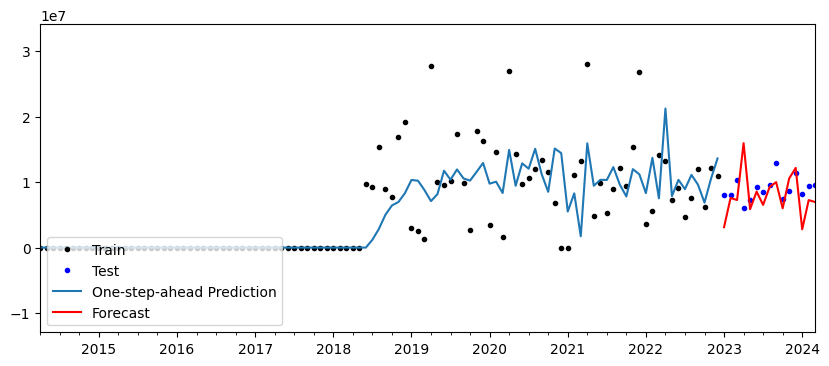

In [ ]:
exog_var2plot = ['AP_lagged']

fig, ax = plt.subplots(figsize=(10,4))

# Plot the results
ssm_train['y'].plot(ax=ax, style='k.', label='Train')
ssm_test['y'].plot(ax=ax, style='b.', label='Test')
predict.predicted_mean.plot(ax=ax, label='One-step-ahead Prediction')
# ssm_train['SM_y'].plot(ax=ax, style='g.', label='Smoothed')
# ssm_data['AP_lagged'].plot(ax=ax, style='g.', label='AP')
# ssm_data['FS_lagged'].plot(ax=ax, style='y.', label='FS')
predict_ci = predict.conf_int(alpha=0.05)
predict_index = np.arange(len(predict_ci))
ax.fill_between(predict_index[2:], predict_ci.iloc[2:, 0], predict_ci.iloc[2:, 1], alpha=0.1)

forecast.predicted_mean.plot(ax=ax, style='r', label='Forecast')
forecast_ci = forecast.conf_int()
forecast_index = np.arange(len(predict_ci), len(predict_ci) + len(forecast_ci))
ax.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], alpha=0.1)

# Cleanup the image
legend = ax.legend(loc='lower left');


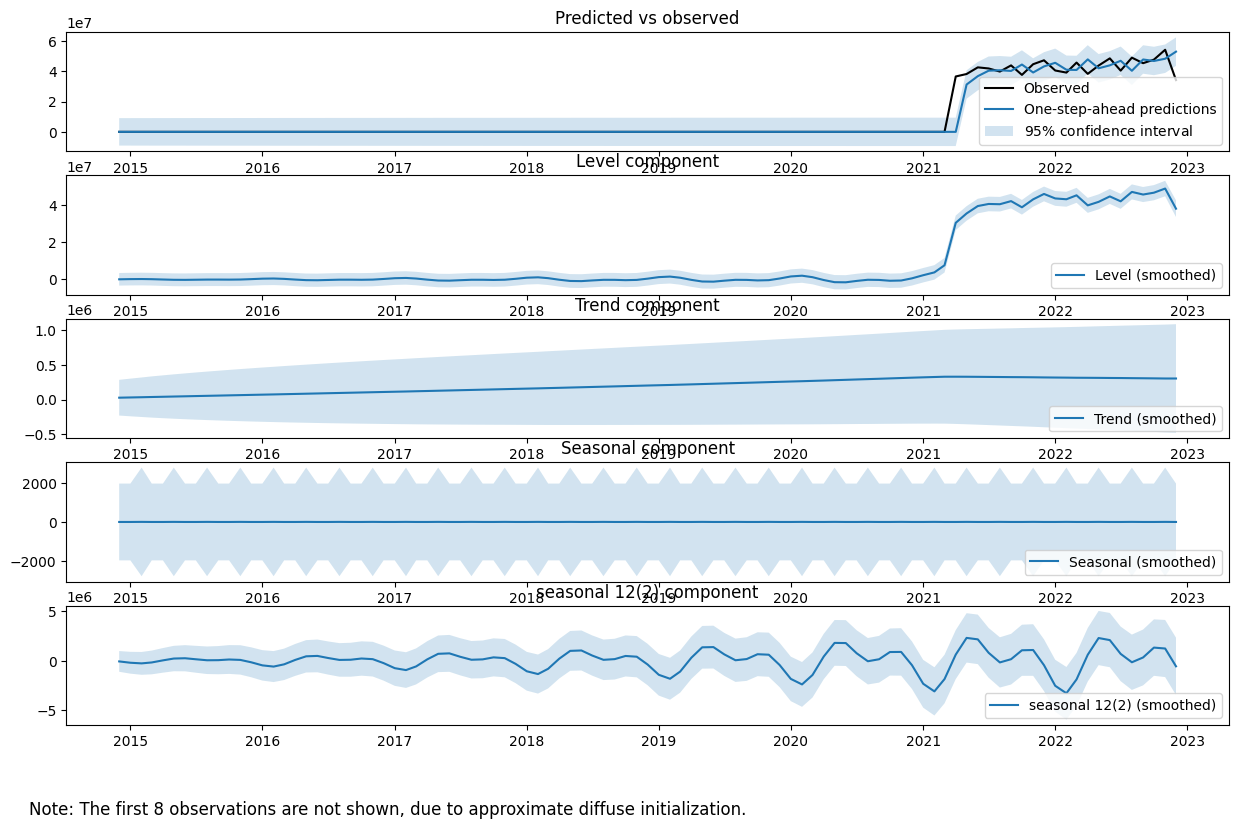

In [ ]:
fig = res.plot_components(legend_loc='lower right', figsize=(15, 9));

# **PARAMETER OPTIMIZATION**

In [ ]:
# Select combinations to run for
inputFile = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/unrestricted_model_settings_volume.csv'
unrestricted_model_settings = pd.read_csv(inputFile, dtype={'autoregressive': 'Int64', 'seasonal': 'Int64'})

unrestricted_model_settings['ID'] = unrestricted_model_settings['Product']+unrestricted_model_settings['Lv5']

unrestricted_model_settings = unrestricted_model_settings[(unrestricted_model_settings['Success']!=1)]
# unrestricted_model_settings = unrestricted_model_settings[~unrestricted_model_settings['ID'].isin(sga1['ID'].unique())]

unrestricted_model_settings = unrestricted_model_settings[unrestricted_model_settings['Product'].isin(['ENZA - Enzalutamide', 'MIRABEGRON - Mirabegron'])]


combinations = unrestricted_model_settings[['Product', 'Lv5']]

# To dictionary
combinations = combinations.rename(columns={'Product': 'product2test', 'Lv5': 'lv52test'}).to_dict(orient='records')

# combinations = combinations[0:1]

In [ ]:
combinations

[{'product2test': 'ENZA - Enzalutamide',
  'lv52test': 'D_CN_TOTAL - China Total'},
 {'product2test': 'ENZA - Enzalutamide',
  'lv52test': 'D_E_NETHLND - Netherlands'},
 {'product2test': 'ENZA - Enzalutamide',
  'lv52test': 'D_TW_TOTAL - Taiwan Total'},
 {'product2test': 'MIRABEGRON - Mirabegron',
  'lv52test': 'D_TW_TOTAL - Taiwan Total'},
 {'product2test': 'ENZA - Enzalutamide',
  'lv52test': 'D_I_CO - Domestic Colombia'},
 {'product2test': 'MIRABEGRON - Mirabegron',
  'lv52test': 'D_E_FINLAND - Finland'},
 {'product2test': 'MIRABEGRON - Mirabegron', 'lv52test': 'D_E_IE - Ireland'},
 {'product2test': 'ENZA - Enzalutamide',
  'lv52test': 'D_E_SLOVAKIA - Slovakia'},
 {'product2test': 'ENZA - Enzalutamide', 'lv52test': 'D_E_IL - Israel'},
 {'product2test': 'ENZA - Enzalutamide',
  'lv52test': 'D_I_SAFRICA - South Africa'},
 {'product2test': 'MIRABEGRON - Mirabegron',
  'lv52test': 'D_I_SAFRICA - South Africa'},
 {'product2test': 'ENZA - Enzalutamide', 'lv52test': 'D_E_RS - Serbia'},
 {'

In [ ]:
unrestricted_model_settings['Product'].value_counts()

Product
SOLIFENACN - Solifenacin Succinate        14
TACRO_XL - Tacrolimus Extended-Release    13
ENZA - Enzalutamide                       13
TACROLIMUS - Tacrolimus                   12
MIRABEGRON - Mirabegron                   12
MICAFUNGIN - Micafungin Sodium            10
ENFORTUMAB - Enforumab Vedotin            10
TAMSUL_TAB - Tamsulosin tab                8
GILTERITNB - Gilteritinib                  8
TAMSULOSIN - Tamsulosin HCl                7
ROXADUSTNT - Roxadustant                   5
FEBUXOSTAT - FEBUXOSTAT                    3
ESCHERICH - Escherichia coli ext           2
SOLIF_TAMS - Solifenacin _ Tamsulosin      2
FEZO - Fezolinetant                        2
ISA_SULFAT - Isavuconazonium Sulfate       1
POLYCARBOP - POLYCARBOP                    1
MINODRONAT - MINODRONAT                    1
AMPHOTERCN - Amphotericin B                1
GABAPENTIN - GABAPENTIN                    1
ZOLPIDEM - ZOLPIDEM                        1
NATEGLINID - NATEGLINID                    1
RA

In [ ]:
def optimize_uc_model(data_train, data_test, fct_st_date):
    # Seasonal and autoregressive
    seasonal_values = [3, 6, 12, 18]
    ar_values = [None, 1, 2, 3]  # Updated to include None
    true_values = [1]
    false_values = [0]

    # Define all possible values for each boolean parameter
    boolean_params = [0, 1]

    # Create all combinations of parameters
    all_combinations = list(product(boolean_params, range(len(ar_values)), true_values, boolean_params,
                                    boolean_params, boolean_params, boolean_params, boolean_params,
                                    boolean_params, seasonal_values, boolean_params))

    best_error = float('inf')
    best_params = None

    # Iterate over all combinations
    for combo in all_combinations:
        model_params = {
            'irregular': bool(combo[0]),
            'autoregressive': ar_values[combo[1]],  # Use index to fetch correct value, including None
            'level': bool(combo[2]),
            'stochastic_level': bool(combo[3]),
            'trend': bool(combo[4]),
            'stochastic_trend': bool(combo[5]),
            'cycle': bool(combo[6]),
            'damped_cycle': bool(combo[7]),
            'stochastic_cycle': bool(combo[8]),
            'seasonal': combo[9],
            'stochastic_seasonal': bool(combo[10])
        }

        try:
            # Fit the model
            mod = sm.tsa.UnobservedComponents(data_train['y'], **model_params)
            res = mod.fit(method='powell', disp=False)

            # Forecasting
            forecast = res.get_forecast(steps=len(data_test))
            forecast_values = forecast.predicted_mean

            actuals = data_test.loc[data_test.index >= fct_st_date]['y'].sum()

            forecasted = forecast_values.loc[forecast_values.index >= fct_st_date].sum()

            # Calculate error
            error = (forecasted - actuals)

            # Store the best parameters
            if np.abs(error) < np.abs(best_error):
                if actuals == 0:
                    best_error_percentage = f"No actuals, forecasted value is: {forecasted}"
                else:
                    best_error_percentage = ((forecasted - actuals) / actuals) * 100

                best_error = error
                best_params = model_params
                print(f"Forecast: {forecasted} Actuals: {actuals}")
                print(f"New best error: {best_error_percentage} with params: {best_params}")
        except Exception as e:
            print(f"An error occurred with params {model_params}: {e}")

    return best_params, best_error_percentage

start_time = datetime.now()

# DataFrame to store results
results_df = pd.DataFrame(columns=['Product', 'Market'])  # Initialize with only these two columns

# Loop over each combination
for combo in combinations:
    product2test = combo['product2test']
    lv52test = combo['lv52test']

    # Fetch unique ID for the current combination
    id2test = volume_act[(volume_act['ProductLv'] == product2test) & (volume_act['Lv5'] == lv52test)]['unique_id'].unique()[0]

    # Filter and prepare data
    ssm_data = volume_act[volume_act['unique_id'] == id2test]
    ssm_data = ssm_data[['ds', 'y']]
    ssm_data = ssm_data.set_index('ds')
    ssm_data.index = pd.DatetimeIndex(ssm_data.index.values, freq=ssm_data.index.inferred_freq)

    # Split data into training and testing sets
    ssm_test = ssm_data.tail(fct_periods)
    ssm_train = ssm_data.drop(ssm_test.index)

    # Run optimization
    best_params, minimum_error = optimize_uc_model(ssm_train, ssm_test, fct_st_date)

    # Extract each parameter into its own column and create a single-row DataFrame
    param_data = {'Product': product2test, 'Market': lv52test}
    param_data.update(best_params)  # This adds each key-value pair from best_params as a column
    param_data['Minimum Error'] = minimum_error

    # Append results to the main results DataFrame
    current_result = pd.DataFrame([param_data])  # List of dictionary ensures single row
    results_df = pd.concat([results_df, current_result], ignore_index=True)

# Rearrange columns to ensure Minimum Error is the third column
cols = results_df.columns.tolist()
cols.insert(2, cols.pop(cols.index('Minimum Error')))  # Move 'Minimum Error' to third position
results_df = results_df[cols]

results_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/results/Blind Test FY23 Volume/optimized_params10_enza_mira.csv', index=False)

end_time = datetime.now()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 11523.752352677626 Actuals: 70435.0
New best error: -83.63916752654556 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 52627.99999999994 Actuals: 70435.0
New best error: -25.281465180663105 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 55835.789002487705 Actuals: 70435.0
New best error: -20.727210900138136 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}
Forecast: 83721.17796573885 Actuals: 70435.0
New best error: 18.863033954339254 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Spec

Forecast: 60518.48759090958 Actuals: 70435.0
New best error: -14.078955645759098 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 71026.69611969324 Actuals: 70435.0
New best error: 0.8400597993799089 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 70282.26451763957 Actuals: 70435.0
New best error: -0.2168460032092362 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Spec

Forecast: 70450.91930822279 Actuals: 70435.0
New best error: 0.02260141722550811 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 70420.53967356421 Actuals: 70435.0
New best error: -0.020530029723555842 with params: {'irregular': True, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1030: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python

Forecast: 70449.3759235596 Actuals: 70435.0
New best error: 0.020410198849426422 with params: {'irregular': True, 'autoregressive': 2, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 18, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1030: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1030: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a s

Forecast: 12082.574522927596 Actuals: 19503.0
New best error: -38.047610506447235 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 23833.999999999996 Actuals: 19503.0
New best error: 22.206839973337416 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 23087.701937672296 Actuals: 19503.0
New best error: 18.38025912768444 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 18, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 16773.815184379873 Actuals: 19503.0
New best error: -13.993666695483395 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 21978.420717088815 Actuals: 19503.0
New best error: 12.692512521605984 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 18, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 18253.499911939565 Actuals: 19503.0
New best error: -6.406707112036275 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': False}
Forecast: 19705.16622039793 Actuals: 19503.0
New best error: 1.0365903727525434 with params: {'irregular': False, 'autoregressive': 1, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
Forecast: 19684.794921519744 Actuals: 19503.0
New best error: 0.9321382429356719 with params: {'irregular': False, 'autoregressive': 1, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}
Forecas

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 4113.722496939915 Actuals: 0.0
New best error: No actuals, forecasted value is: 4113.722496939915 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 3930.055840922286 Actuals: 0.0
New best error: No actuals, forecasted value is: 3930.055840922286 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 482.69231856222785 Actuals: 0.0
New best error: No actuals, forecasted value is: 482.69231856222785 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 449.40102446238575 Actuals: 0.0
New best error: No actuals, forecasted value is: 449.40102446238575 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 12, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1030: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespa

Forecast: -330.3691451292599 Actuals: 0.0
New best error: No actuals, forecasted value is: -330.3691451292599 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': True}
Forecast: 242.9023670363047 Actuals: 0.0
New best error: No actuals, forecasted value is: 242.9023670363047 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 18, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: -103.43795199998047 Actuals: 0.0
New best error: No actuals, forecasted value is: -103.43795199998047 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 12, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: -103.43007587640017 Actuals: 0.0
New best error: No actuals, forecasted value is: -103.43007587640017 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': False, 'seasonal': 12, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: -67.99667357733817 Actuals: 0.0
New best error: No actuals, forecasted value is: -67.99667357733817 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
Forecast: 57.11700402610025 Actuals: 0.0
New best error: No actuals, forecasted value is: 57.11700402610025 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': True}
Forecast: -37.56148832040756 Actuals: 0.0
New best error: No actuals, forecasted value is: -37.56148832040756 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_c

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: -0.807612551694854 Actuals: 0.0
New best error: No actuals, forecasted value is: -0.807612551694854 with params: {'irregular': False, 'autoregressive': 1, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}
Forecast: -0.3737036415864168 Actuals: 0.0
New best error: No actuals, forecasted value is: -0.3737036415864168 with params: {'irregular': False, 'autoregressive': 1, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1030: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python

Forecast: -0.35397013738323757 Actuals: 0.0
New best error: No actuals, forecasted value is: -0.35397013738323757 with params: {'irregular': False, 'autoregressive': 1, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 6, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: -0.35396625771531687 Actuals: 0.0
New best error: No actuals, forecasted value is: -0.35396625771531687 with params: {'irregular': True, 'autoregressive': 1, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 6, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 901.8921986643338 Actuals: 0.0
New best error: No actuals, forecasted value is: 901.8921986643338 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
Forecast: 470.59308488723684 Actuals: 0.0
New best error: No actuals, forecasted value is: 470.59308488723684 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}
Forecast: 468.1292651107069 Actuals: 0.0
New best error: No actuals, forecasted value is: 468.1292651107069 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 266.31973924364513 Actuals: 0.0
New best error: No actuals, forecasted value is: 266.31973924364513 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': False}
Forecast: 193.45691980168417 Actuals: 0.0
New best error: No actuals, forecasted value is: 193.45691980168417 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 12, 'stochastic_seasonal': False}
Forecast: 28.411468163993028 Actuals: 0.0
New best error: No actuals, forecasted value is: 28.411468163993028 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damp

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 14.815320298208036 Actuals: 0.0
New best error: No actuals, forecasted value is: 14.815320298208036 with params: {'irregular': False, 'autoregressive': 2, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 12, 'stochastic_seasonal': False}
Forecast: 12.97097671254757 Actuals: 0.0
New best error: No actuals, forecasted value is: 12.97097671254757 with params: {'irregular': False, 'autoregressive': 2, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 6609.823479503776 Actuals: 16386.3571363
New best error: -59.66264237667984 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
Forecast: 6610.028550630676 Actuals: 16386.3571363
New best error: -59.66139090189997 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 16992.785710299886 Actuals: 16386.3571363
New best error: 3.7008138474932264 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 16570.45612675136 Actuals: 16386.3571363
New best error: 1.1234894303843306 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
Forecast: 16454.105205227977 Actuals: 16386.3571363
New best error: 0.41344191612849085 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 16454.046432677434 Actuals: 16386.3571363
New best error: 0.41308324854878375 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 12, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 16453.21336619501 Actuals: 16386.3571363
New best error: 0.4079993456685098 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': False, 'seasonal': 12, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 16410.200881655488 Actuals: 16386.3571363
New best error: 0.1455097381141963 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}
Forecast: 16398.376575879298 Actuals: 16386.3571363
New best error: 0.07335028450387385 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1030: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python

Forecast: 16386.68393850477 Actuals: 16386.3571363
New best error: 0.001994355438809219 with params: {'irregular': False, 'autoregressive': 1, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': False}
Forecast: 16386.275787438306 Actuals: 16386.3571363
New best error: -0.0004964426261331547 with params: {'irregular': False, 'autoregressive': 1, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': True}
Forecast: 16386.27625491281 Actuals: 16386.3571363
New best error: -0.0004935897986294545 with params: {'irregular': False, 'autoregressive': 1, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 6, 'stochastic_seas

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 16386.333661484903 Actuals: 16386.3571363
New best error: -0.0001432582904339827 with params: {'irregular': False, 'autoregressive': 1, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 1107.6138009032209 Actuals: 13599450.0
New best error: -99.99185545150058 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 12026909.999999955 Actuals: 13599450.0
New best error: -11.563261749556377 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 12496114.080677163 Actuals: 13599450.0
New best error: -8.113092215661936 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 6, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Spec

Forecast: 13870274.025014607 Actuals: 13599450.0
New best error: 1.9914336610275214 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 13859165.155093132 Actuals: 13599450.0
New best error: 1.9097474904730085 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Spec

Forecast: 13694623.764002835 Actuals: 13599450.0
New best error: 0.6998353904226668 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 13504938.6769318 Actuals: 13599450.0
New best error: -0.694964304204947 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 12, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 13673749.62686139 Actuals: 13599450.0
New best error: 0.5463428804943562 with params: {'irregular': False, 'autoregressive': 1, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 12, 'stochastic_seasonal': True}
Forecast: 13654488.736335956 Actuals: 13599450.0
New best error: 0.40471295777370087 with params: {'irregular': False, 'autoregressive': 1, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': True}
Forecast: 13651326.329782292 Actuals: 13599450.0
New best error: 0.3814590279922515 with params: {'irregular': False, 'autoregressive': 1, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': True}
Fore

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 13577378.114596508 Actuals: 13599450.0
New best error: -0.16229983862208808 with params: {'irregular': False, 'autoregressive': 2, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 13591265.682084108 Actuals: 13599450.0
New best error: -0.06018124200531807 with params: {'irregular': True, 'autoregressive': 1, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': True}
Forecast: 13593138.437938157 Actuals: 13599450.0
New best error: -0.04641042146441607 with params: {'irregular': True, 'autoregressive': 1, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 2374.3535901818805 Actuals: 8601840.0
New best error: -99.97239714305101 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 8166810.000000002 Actuals: 8601840.0
New best error: -5.057406322368216 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 8446687.493294299 Actuals: 8601840.0
New best error: -1.8037130044932403 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}
Forecast: 8454029.171196979 Actuals: 8601840.0
New best error: -1.718362917736455 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 8517012.657784251 Actuals: 8601840.0
New best error: -0.9861534533977441 with params: {'irregular': False, 'autoregressive': 1, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': False}
Forecast: 8540956.098149601 Actuals: 8601840.0
New best error: -0.7078009106237576 with params: {'irregular': False, 'autoregressive': 1, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': True}
Forecast: 8650220.258276237 Actuals: 8601840.0
New best error: 0.5624408065743745 with params: {'irregular': False, 'autoregressive': 1, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 6, 'stochastic_seasonal': True}
Forecast: 862

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 8604239.703746606 Actuals: 8601840.0
New best error: 0.027897563156320793 with params: {'irregular': False, 'autoregressive': 1, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 2042.5610252310491 Actuals: 5000.0
New best error: -59.148779495379024 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 4799.999999999987 Actuals: 5000.0
New best error: -4.000000000000255 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 4800.000000000011 Actuals: 5000.0
New best error: -3.9999999999997815 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 4861.594320287766 Actuals: 5000.0
New best error: -2.768113594244678 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1030: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 4974.938225562603 Actuals: 5000.0
New best error: -0.5012354887479341 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1030: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 5006.99112298134 Actuals: 5000.0
New best error: 0.1398224596267937 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 6, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1030: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWar

Forecast: 5006.9898437320835 Actuals: 5000.0
New best error: 0.13979687464167 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 6, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 5003.1757460527215 Actuals: 5000.0
New best error: 0.06351492105442957 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.1

Forecast: 5000.011927090863 Actuals: 5000.0
New best error: 0.0002385418172525533 with params: {'irregular': False, 'autoregressive': 1, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 6, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 1986.7295401322503 Actuals: 3265.0
New best error: -39.15070321187595 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
Forecast: 1989.689580507872 Actuals: 3265.0
New best error: -39.060043476022294 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 2831.9999999999986 Actuals: 3265.0
New best error: -13.261868300153182 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 2832.0000000000045 Actuals: 3265.0
New best error: -13.261868300153 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 3460.179902326663 Actuals: 3265.0
New best error: 5.977944941092284 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1030: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python

Forecast: 3237.85320088461 Actuals: 3265.0
New best error: -0.8314486712217448 with params: {'irregular': False, 'autoregressive': 1, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 3242.885233207775 Actuals: 3265.0
New best error: -0.6773282325336923 with params: {'irregular': False, 'autoregressive': 3, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 12, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 3279.033735605659 Actuals: 3265.0
New best error: 0.42982344887163476 with params: {'irregular': False, 'autoregressive': 3, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 1403.1109997192318 Actuals: 4554.0
New best error: -69.1894817804297 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 3226.9999999999977 Actuals: 4554.0
New best error: -29.1392182696531 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 3773.7206046859637 Actuals: 4554.0
New best error: -17.13393489929812 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Spec

Forecast: 4040.873204306774 Actuals: 4554.0
New best error: -11.26760640520918 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
Forecast: 4065.8680328634823 Actuals: 4554.0
New best error: -10.718752023199773 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}
Forecast: 4077.887663795585 Actuals: 4554.0
New best error: -10.454816341774594 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 4121.439692106481 Actuals: 4554.0
New best error: -9.49846965071408 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 12, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 4849.839161578933 Actuals: 4554.0
New best error: 6.496248607354706 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 4479.222742218432 Actuals: 4554.0
New best error: -1.6420126873422844 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Spec

Forecast: 4479.274417833727 Actuals: 4554.0
New best error: -1.6408779570986594 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 4524.179439385047 Actuals: 4554.0
New best error: -0.6548212695422296 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 18, 'stochastic_seasonal': False}
Forecast: 4542.73068827319 Actuals: 4554.0
New best error: -0.24745963387812855 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1030: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python

Forecast: 4563.7184877294085 Actuals: 4554.0
New best error: 0.21340552765499515 with params: {'irregular': False, 'autoregressive': 1, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 6, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 4544.933386039294 Actuals: 4554.0
New best error: -0.19909121565010057 with params: {'irregular': False, 'autoregressive': 1, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 4558.358603528991 Actuals: 4554.0
New best error: 0.09570934407094638 with params: {'irregular': False, 'autoregressive': 2, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
Forecast: 4557.2345155971525 Actuals: 4554.0
New best error: 0.0710258146058958 with params: {'irregular': False, 'autoregressive': 2, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': False}
Forecast: 4557.035609016154 Actuals: 4554.0
New best error: 0.0666580811628022 with params: {'irregular': False, 'autoregressive': 2, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 2888.434524083494 Actuals: 7037010.0
New best error: -99.95895366747975 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 5880090.000000035 Actuals: 7037010.0
New best error: -16.440505271414487 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 6683439.105168616 Actuals: 7037010.0
New best error: -5.024447809955984 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Spec

Forecast: 6784051.639203569 Actuals: 7037010.0
New best error: -3.5946852540557863 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 7097788.799350457 Actuals: 7037010.0
New best error: 0.8637020460459381 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}
Forecast: 7057256.367573777 Actuals: 7037010.0
New best error: 0.287712644628574 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 7022020.178214644 Actuals: 7037010.0
New best error: -0.21301407537229472 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 7034823.844261245 Actuals: 7037010.0
New best error: -0.031066543016922375 with params: {'irregular': False, 'autoregressive': 1, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 840.0537190481598 Actuals: 3403.0
New best error: -75.31431915814987 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 2415.0 Actuals: 3403.0
New best error: -29.03320599471055 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 3271.18377255867 Actuals: 3403.0
New best error: -3.8735300452932657 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Spec

Forecast: 3290.025717104214 Actuals: 3403.0
New best error: -3.3198437524474294 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 3505.964452067691 Actuals: 3403.0
New best error: 3.025696505074673 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
Forecast: 3447.822827795355 Actuals: 3403.0
New best error: 1.3171562678623243 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 3442.8414602482994 Actuals: 3403.0
New best error: 1.1707746179341587 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 3442.841460050519 Actuals: 3403.0
New best error: 1.1707746121222125 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 3378.92252041316 Actuals: 3403.0
New best error: -0.7075368670831657 with params: {'irregular': False, 'autoregressive': 2, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 18, 'stochastic_seasonal': False}
Forecast: 3378.9844300186146 Actuals: 3403.0
New best error: -0.7057176015687745 with params: {'irregular': False, 'autoregressive': 2, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 2652.7326591477226 Actuals: 5319600.0
New best error: -99.95013285474194 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
Forecast: 2711.63466656144 Actuals: 5319600.0
New best error: -99.94902559089854 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': True}
Forecast: 5211.7483433911 Actuals: 5319600.0
New best error: -99.9020274392174 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 12, 'stochastic_seasonal': Tr

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 3919243.6386687444 Actuals: 5319600.0
New best error: -26.324467278202413 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': False}
Forecast: 3921055.582942059 Actuals: 5319600.0
New best error: -26.290405614293206 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 6, 'stochastic_seasonal': False}
Forecast: 3922711.8320469256 Actuals: 5319600.0
New best error: -26.25927077135639 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 3967842.517177172 Actuals: 5319600.0
New best error: -25.41088583395045 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': False}
Forecast: 3968196.7254225668 Actuals: 5319600.0
New best error: -25.4042272835821 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 6, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 4048170.3066572994 Actuals: 5319600.0
New best error: -23.900851442640437 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': False}
Forecast: 4050270.8243634845 Actuals: 5319600.0
New best error: -23.861365058209554 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 6, 'stochastic_seasonal': False}
Forecast: 4235516.485303116 Actuals: 5319600.0
New best error: -20.379041933545455 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': Fa

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 4436520.294956862 Actuals: 5319600.0
New best error: -16.600490733196818 with params: {'irregular': False, 'autoregressive': 3, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 934.2790325834046 Actuals: 10221030.0
New best error: -99.99085924772176 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
Forecast: 1012.1672805938903 Actuals: 10221030.0
New best error: -99.99009720859254 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}
Forecast: 1264.1581465268027 Actuals: 10221030.0
New best error: -99.98763179301375 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_season

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 8378699.999331543 Actuals: 10221030.0
New best error: -18.02489573622675 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Spec

Forecast: 8400977.422671992 Actuals: 10221030.0
New best error: -17.8069390005509 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Spec

Forecast: 9980667.768480612 Actuals: 10221030.0
New best error: -2.351643929421869 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}
Forecast: 10219424.225548014 Actuals: 10221030.0
New best error: -0.01571049543916763 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 55.428256868228615 Actuals: 2210.0
New best error: -97.49193407836069 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
Forecast: 56.50420193016705 Actuals: 2210.0
New best error: -97.44324878144039 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}
Forecast: 58.198400660981626 Actuals: 2210.0
New best error: -97.36658820538545 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': True}
F

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 90.3320473467322 Actuals: 2210.0
New best error: -95.91257704313429 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 102.0307740104385 Actuals: 2210.0
New best error: -95.38322289545526 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': False}
Forecast: 121.13339860387663 Actuals: 2210.0
New best error: -94.51885074190604 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Spec

Forecast: 134.41950240475532 Actuals: 2210.0
New best error: -93.91766957444545 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
Forecast: 143.56296426623857 Actuals: 2210.0
New best error: -93.503938268496 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}
Forecast: 153.33059038629486 Actuals: 2210.0
New best error: -93.06196423591426 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': True}
Forec

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 176.9038811922768 Actuals: 2210.0
New best error: -91.99529949356213 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py

Forecast: 177.23821581562999 Actuals: 2210.0
New best error: -91.98017123006198 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': False, 'seasonal': 12, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.1

Forecast: 342.9768906163293 Actuals: 2210.0
New best error: -84.48068368251904 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 348.52369355348617 Actuals: 2210.0
New best error: -84.22969712427664 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 3617.964381724282 Actuals: 2651850.0
New best error: -99.86356828697987 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
Forecast: 4394.980545701205 Actuals: 2651850.0
New best error: -99.83426737765329 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}
Forecast: 5042.529399503579 Actuals: 2651850.0
New best error: -99.80984861890742 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 1368456.290424173 Actuals: 2651850.0
New best error: -48.396165302555836 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 6, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Spec

Forecast: 1427962.3295875348 Actuals: 2651850.0
New best error: -46.15222091794276 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 1429147.2842007694 Actuals: 2651850.0
New best error: -46.10753684406097 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}
Forecast: 1542171.7445681624 Actuals: 2651850.0
New best error: -41.84543829522174 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 6, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Spec

Forecast: 3097383.687975215 Actuals: 2651850.0
New best error: 16.80086309464015 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 12, 'stochastic_seasonal': True}
Forecast: 3034510.520031798 Actuals: 2651850.0
New best error: 14.429945888032814 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}
Forecast: 3028392.9733780436 Actuals: 2651850.0
New best error: 14.199256118484968 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 2297004.9824953065 Actuals: 2651850.0
New best error: -13.3810365407053 with params: {'irregular': True, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': False, 'seasonal': 12, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 2311192.7948245923 Actuals: 2651850.0
New best error: -12.846020897690583 with params: {'irregular': True, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': False, 'seasonal': 12, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 509.1139713881315 Actuals: 1150.0
New best error: -55.72921987929291 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
Forecast: 510.7775799015515 Actuals: 1150.0
New best error: -55.5845582694303 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 1356.0000000000014 Actuals: 1150.0
New best error: 17.913043478260988 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 1212.0130496426368 Actuals: 1150.0
New best error: 5.392439099359723 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
Forecast: 1205.4286227051136 Actuals: 1150.0
New best error: 4.819880235227273 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 1106.1407709133816 Actuals: 1150.0
New best error: -3.8138460075320326 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Spec

Forecast: 1157.4528409885368 Actuals: 1150.0
New best error: 0.6480731294379795 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 1146.5913642301373 Actuals: 1150.0
New best error: -0.29640311042284456 with params: {'irregular': False, 'autoregressive': 1, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
Forecast: 1146.6471356091818 Actuals: 1150.0
New best error: -0.2915534252885426 with params: {'irregular': False, 'autoregressive': 1, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}
Forecast: 1146.7180145577795 Actuals: 1150.0
New best error: -0.2853900384539568 with params: {'irregular': False, 'autoregressive': 1, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 12, 'stochastic_seasonal': False}
Forecast: 11

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1037: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))


Forecast: 1148.7313575521066 Actuals: 1150.0
New best error: -0.11031673459942597 with params: {'irregular': False, 'autoregressive': 2, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 12, 'stochastic_seasonal': False}
Forecast: 1148.9257034612726 Actuals: 1150.0
New best error: -0.09341709032411888 with params: {'irregular': False, 'autoregressive': 2, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 12, 'stochastic_seasonal': True}
Forecast: 1149.203610804127 Actuals: 1150.0
New best error: -0.06925123442373582 with params: {'irregular': False, 'autoregressive': 2, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1037: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1030: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/pyt

Forecast: 1149.6001292941894 Actuals: 1150.0
New best error: -0.034771365722660805 with params: {'irregular': True, 'autoregressive': 1, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': True}
Forecast: 1150.3835626288028 Actuals: 1150.0
New best error: 0.033353272069808045 with params: {'irregular': True, 'autoregressive': 1, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
Forecast: 1150.3797437135559 Actuals: 1150.0
New best error: 0.03302119248311773 with params: {'irregular': True, 'autoregressive': 1, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}
Forecast: 114

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1037: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 4545.238609329556 Actuals: 3864000.0
New best error: -99.88236960120783 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 3517799.999999992 Actuals: 3864000.0
New best error: -8.95962732919275 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 3841091.9825396226 Actuals: 3864000.0
New best error: -0.5928575947302646 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': False}
Forecast: 3844442.1632732768 Actuals: 3864000.0
New best error: -0.5061551947909742 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 6, 'stochastic_seasonal': False}
Forecast: 3844800.7950778794 Actuals: 3864000.0
New best error: -0.49687383338821306 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Spec

Forecast: 3850847.1396993273 Actuals: 3864000.0
New best error: -0.3403949353176166 with params: {'irregular': False, 'autoregressive': 1, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

An error occurred with params {'irregular': True, 'autoregressive': 2, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': False}: LU decomposition error.
An error occurred with params {'irregular': True, 'autoregressive': 2, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 18, 'stochastic_seasonal': False}: LU decomposition error.
An error occurred with params {'irregular': True, 'autoregressive': 2, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': True, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': False}: LU decomposition error.
An error occurred with params {'irregular': True, 'autoregressive': 2, 'level': True, 'stochastic_level': False, 'trend': F

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1030: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))


An error occurred with params {'irregular': True, 'autoregressive': 2, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': False}: LU decomposition error.
An error occurred with params {'irregular': True, 'autoregressive': 2, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 18, 'stochastic_seasonal': False}: LU decomposition error.
An error occurred with params {'irregular': True, 'autoregressive': 2, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': True, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': False}: LU decomposition error.
An error occurred with params {'irregular': True, 'autoregressive': 2, 'level': True, 'stochastic_level': False, 'trend': Fals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1030: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 303.0830575801233 Actuals: 1623.0
New best error: -81.32575122734916 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 925.9999999999983 Actuals: 1623.0
New best error: -42.945163277880575 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 1470.9479003781362 Actuals: 1623.0
New best error: -9.368582847927529 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': False}
Forecast: 1471.9694778472967 Actuals: 1623.0
New best error: -9.305639072871427 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Spec

Forecast: 1752.3000010226617 Actuals: 1623.0
New best error: 7.966728343971763 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 18, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Spec

Forecast: 1554.6186623920935 Actuals: 1623.0
New best error: -4.213267874793994 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': False}
Forecast: 1671.8455730265441 Actuals: 1623.0
New best error: 3.0095855222762857 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': False}
Forecast: 1652.2960382453798 Actuals: 1623.0
New best error: 1.8050547286124339 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 6, 'stochastic_seasonal': False}
Forecast

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 3139.1812991024453 Actuals: 2480400.0
New best error: -99.87344052172624 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 3209100.000000015 Actuals: 2480400.0
New best error: 29.378326076439887 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 3206066.5654443833 Actuals: 2480400.0
New best error: 29.256029892129625 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Spec

Forecast: 2981264.7010482624 Actuals: 2480400.0
New best error: 20.192900380916885 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
Forecast: 2975985.2776767993 Actuals: 2480400.0
New best error: 19.98005473620381 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': False}
Forecast: 2964579.1388327116 Actuals: 2480400.0
New best error: 19.520203952294455 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 12, 'stochastic_seasonal':

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 2951900.1561852996 Actuals: 2480400.0
New best error: 19.009037098262365 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 2947610.5414792704 Actuals: 2480400.0
New best error: 18.836096656961395 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Spec

Forecast: 2947238.0807611207 Actuals: 2480400.0
New best error: 18.821080501577192 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 2947137.2631894047 Actuals: 2480400.0
New best error: 18.817015932486886 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 18, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 2041151.490538792 Actuals: 2480400.0
New best error: -17.708777191630706 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 2229010.0124181807 Actuals: 2480400.0
New best error: -10.135058360821613 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 2229253.2398524093 Actuals: 2480400.0
New best error: -10.125252384598882 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/opt

Forecast: 2346787.0446372526 Actuals: 2480400.0
New best error: -5.386750337153178 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/opt

Forecast: 2426089.846781255 Actuals: 2480400.0
New best error: -2.189572376179035 with params: {'irregular': False, 'autoregressive': 1, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 6, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 2516740.4699922604 Actuals: 2480400.0
New best error: 1.4651052246516871 with params: {'irregular': False, 'autoregressive': 2, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 18, 'stochastic_seasonal': False}
Forecast: 2509940.983722842 Actuals: 2480400.0
New best error: 1.1909766055007995 with params: {'irregular': False, 'autoregressive': 2, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1030: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1030: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1030: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1030: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))


Forecast: 2501082.04474891 Actuals: 2480400.0
New best error: 0.8338189303704955 with params: {'irregular': False, 'autoregressive': 3, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': False}
Forecast: 2501004.826749705 Actuals: 2480400.0
New best error: 0.8307058034875334 with params: {'irregular': False, 'autoregressive': 3, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': True}
Forecast: 2466689.636419919 Actuals: 2480400.0
New best error: -0.5527480882148503 with params: {'irregular': False, 'autoregressive': 3, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 12, 'stochastic_seasonal': False}
Fore

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 12803.52234939006 Actuals: 1649550.0
New best error: -99.22381726232064 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 1302749.999999994 Actuals: 1649550.0
New best error: -21.023915613349462 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 1302750.000000006 Actuals: 1649550.0
New best error: -21.023915613348727 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/opt

Forecast: 1345363.2304415484 Actuals: 1649550.0
New best error: -18.440591043524087 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
Forecast: 1346943.4347577817 Actuals: 1649550.0
New best error: -18.34479495875956 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 1505090.5083756782 Actuals: 1649550.0
New best error: -8.757509116081463 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 1506675.234283917 Actuals: 1649550.0
New best error: -8.661438920680373 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Spec

Forecast: 1556382.1944150007 Actuals: 1649550.0
New best error: -5.648074055651497 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 1682447.325670089 Actuals: 1649550.0
New best error: 1.9943212191257682 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/opt

Forecast: 1682356.6470299321 Actuals: 1649550.0
New best error: 1.9888240447353596 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 1618157.9301509317 Actuals: 1649550.0
New best error: -1.903068706560474 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1030: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python

Forecast: 1619141.9540978803 Actuals: 1649550.0
New best error: -1.8434146222981853 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}
Forecast: 1647482.747306095 Actuals: 1649550.0
New best error: -0.12532222084235273 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


Forecast: 1647550.996875476 Actuals: 1649550.0
New best error: -0.12118475490430167 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 1650949.5227538587 Actuals: 1649550.0
New best error: 0.0848426997580374 with params: {'irregular': False, 'autoregressive': 1, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 12, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 1648151.1439834782 Actuals: 1649550.0
New best error: -0.08480228041113078 with params: {'irregular': False, 'autoregressive': 3, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1037: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))


Forecast: 1648819.8386033725 Actuals: 1649550.0
New best error: -0.04426427793201462 with params: {'irregular': False, 'autoregressive': 3, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

An error occurred with params {'irregular': True, 'autoregressive': 2, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 12, 'stochastic_seasonal': True}: LU decomposition error.
An error occurred with params {'irregular': True, 'autoregressive': 2, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}: LU decomposition error.
An error occurred with params {'irregular': True, 'autoregressive': 2, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': True}: LU decomposition error.
An error occurred with params {'irregular': True, 'autoregressive': 2, 'level': True, 'stochastic_level': False, 'trend': Fal

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1030: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1030: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/pyt

An error occurred with params {'irregular': True, 'autoregressive': 2, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 12, 'stochastic_seasonal': True}: LU decomposition error.
An error occurred with params {'irregular': True, 'autoregressive': 2, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}: LU decomposition error.
An error occurred with params {'irregular': True, 'autoregressive': 2, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': True}: LU decomposition error.
An error occurred with params {'irregular': True, 'autoregressive': 2, 'level': True, 'stochastic_level': False, 'trend': False,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1030: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1030: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/pyt

An error occurred with params {'irregular': True, 'autoregressive': 3, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}: LU decomposition error.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1030: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))


An error occurred with params {'irregular': True, 'autoregressive': 3, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}: LU decomposition error.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1037: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 3129.2101262832343 Actuals: 1079460.0
New best error: -99.7101133783296 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
Forecast: 3504.3380809540463 Actuals: 1079460.0
New best error: -99.67536193272988 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}
Forecast: 4193.967872979294 Actuals: 1079460.0
New best error: -99.61147537908033 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal':

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 2139284.504936203 Actuals: 1079460.0
New best error: 98.18098909975384 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}
Forecast: 822807.2010127609 Actuals: 1079460.0
New best error: -23.776036072410196 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Spec

Forecast: 1208348.412835278 Actuals: 1079460.0
New best error: 11.940082340733152 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Spec

Forecast: 962249.2711275592 Actuals: 1079460.0
New best error: -10.85827440316832 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': True}
Forecast: 963129.4951120822 Actuals: 1079460.0
New best error: -10.776731410883013 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 968268.4590678012 Actuals: 1079460.0
New best error: -10.300663380968146 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 1103107.623947747 Actuals: 1079460.0
New best error: 2.190690155054106 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 12, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 1103038.2053765412 Actuals: 1079460.0
New best error: 2.1842592941416306 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 12, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 1086131.5728182828 Actuals: 1079460.0
New best error: 0.6180472475388397 with params: {'irregular': False, 'autoregressive': 3, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 1073753.5911208508 Actuals: 1079460.0
New best error: -0.528635510268953 with params: {'irregular': True, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 1082535.3212593955 Actuals: 1079460.0
New best error: 0.28489441567037704 with params: {'irregular': True, 'autoregressive': 1, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 6949.560281327961 Actuals: 349500.0
New best error: -98.01157073495624 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 521790.00000000466 Actuals: 349500.0
New best error: 49.296137339057125 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 513405.39677562605 Actuals: 349500.0
New best error: 46.89710923480001 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Spec

Forecast: 293522.19623428315 Actuals: 349500.0
New best error: -16.016538988760185 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}
Forecast: 319404.6344923703 Actuals: 349500.0
New best error: -8.610977255401917 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 323243.940899723 Actuals: 349500.0
New best error: -7.512463261881838 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 324861.2039258235 Actuals: 349500.0
New best error: -7.0497270598502135 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 335557.67320265365 Actuals: 349500.0
New best error: -3.9892208289975257 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 336836.32488449034 Actuals: 349500.0
New best error: -3.6233691317624195 with params: {'irregular': False, 'autoregressive': 1, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 18, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 337145.0168246405 Actuals: 349500.0
New best error: -3.5350452576135885 with params: {'irregular': False, 'autoregressive': 1, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 18, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


Forecast: 346515.1104410526 Actuals: 349500.0
New best error: -0.8540456534899605 with params: {'irregular': False, 'autoregressive': 3, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
Forecast: 352452.73422727856 Actuals: 349500.0
New best error: 0.8448452724688299 with params: {'irregular': False, 'autoregressive': 3, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}
Forecast: 351418.0165678624 Actuals: 349500.0
New best error: 0.5487887175572012 with params: {'irregular': False, 'autoregressive': 3, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}
Forecast

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 0.9142857109600624 Actuals: 0.0
New best error: No actuals, forecasted value is: 0.9142857109600624 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
Forecast: 0.9019607813446645 Actuals: 0.0
New best error: No actuals, forecasted value is: 0.9019607813446645 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': False}
Forecast: 0.8888888869216895 Actuals: 0.0
New best error: No actuals, forecasted value is: 0.8888888869216895 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'da

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: -0.3389134932877589 Actuals: 0.0
New best error: No actuals, forecasted value is: -0.3389134932877589 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}
Forecast: -0.32307515257268615 Actuals: 0.0
New best error: No actuals, forecasted value is: -0.32307515257268615 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


Forecast: 0.213931097623062 Actuals: 0.0
New best error: No actuals, forecasted value is: 0.213931097623062 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Spec

Forecast: 0.0 Actuals: 0.0
New best error: No actuals, forecasted value is: 0.0 with params: {'irregular': False, 'autoregressive': 2, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 4008.894699518023 Actuals: 3745.9285703
New best error: 7.020051885211546 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
Forecast: 3982.6114711014197 Actuals: 3745.9285703
New best error: 6.318404004763617 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': False}
Forecast: 3978.0545074914357 Actuals: 3745.9285703
New best error: 6.196752896781623 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 12, 'stochastic_s

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

Forecast: 3972.7339932633326 Actuals: 3745.9285703
New best error: 6.05471830834106 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': False}
Forecast: 3972.733993195247 Actuals: 3745.9285703
New best error: 6.054718306523468 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 3858.0749599393585 Actuals: 3745.9285703
New best error: 2.9938208253228105 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 3663.0221835779944 Actuals: 3745.9285703
New best error: -2.2132399261250715 with params: {'irregular': False, 'autoregressive': 1, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': False}
Forecast: 3747.647950691485 Actuals: 3745.9285703
New best error: 0.04589997804863306 with params: {'irregular': False, 'autoregressive': 1, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast: 3746.3213288380825 Actuals: 3745.9285703
New best error: 0.010484944672904816 with params: {'irregular': False, 'autoregressive': 3, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


Forecast: 3746.321195872178 Actuals: 3745.9285703
New best error: 0.010481395061589016 with params: {'irregular': False, 'autoregressive': 3, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

In [ ]:
(end_time-start_time)

datetime.timedelta(seconds=2007, microseconds=439357)

In [ ]:
results_df

Product                     Market  \
0  MIRABEGRON - Mirabegron  D_TW_TOTAL - Taiwan Total   

                                       Minimum Error irregular autoregressive  \
0  No actuals, forecasted value is: 16.2201194995...     False           None   

  level stochastic_level trend stochastic_trend cycle damped_cycle  \
0  True             True  True            False  True        False   

  stochastic_cycle  seasonal stochastic_seasonal  
0            False     18.00               False

# **BULK RUN**

In [ ]:
def forecast_error(df, volume_act, exog_df, fct_periods, fct_st_date):
    # Initialize the output DataFrame
    results = pd.DataFrame(columns=['id2test', 'Product', 'Lv5', 'actuals_fy23', 'forecast_fy23', 'error'])
    results_monthly = pd.DataFrame(columns=['id2test', 'Product', 'Lv5', 'ds', 'Actuals', 'DX'])

    # Iterate through each row in the DataFrame
    for idx, row in df.iterrows():
        product = row['Product']
        Lv5 = row['Lv5']
        model_settings = row.drop(['Product', 'Lv5', 'exog']).to_dict()

        if row['exog']:
            exog2include = {k: v for d in row['exog'] for k, v in d.items()}
            exog_names = list(exog2include.keys())
        else:
            exog2include = None
            exog_names = []

        print(exog2include)
        print(product)
        print(Lv5)
        # Determine unique ID based on product and Lv5
        id2test = volume_act[(volume_act['ProductLv'] == product) & (volume_act['Lv5'] == Lv5)]['unique_id'].unique()[0]

        # Filter the data for this specific ID
        ssm_data = volume_act[volume_act['unique_id'] == id2test]

        # Add exog variables
        ssm_data = ssm_data.merge(exog_df[['unique_id', 'ds'] + exog_names], how='left', on=['unique_id', 'ds'])
        ssm_data = ssm_data[['ds', 'y'] + exog_names]

        # Efficiently fill NaNs with 0 in the specified columns
        ssm_data.loc[:, exog_names] = ssm_data.loc[:, exog_names].fillna(0)

        if exog2include is not None:
            for column, lag in exog2include.items():
                # Create new lagged column for each key in the dictionary
                ssm_data[column] = ssm_data[column].shift(lag).fillna(0)

        # Set ds as index
        ssm_data = ssm_data.set_index('ds')
        ssm_data.index = pd.DatetimeIndex(ssm_data.index.values, freq=ssm_data.index.inferred_freq)

        # Set train and test period
        ssm_test = ssm_data.tail(fct_periods)
        ssm_train = ssm_data.drop(ssm_test.index)

        if row['exog']:
            exog_test = ssm_test[exog_names]
            exog_train = ssm_train[exog_names]
        else:
            exog_test = None
            exog_train = None

        # Fit the model
        mod = sm.tsa.UnobservedComponents(ssm_train['y'], exog = exog_train, **model_settings)
        res = mod.fit(method='powell', disp=False)

        # Perform prediction and forecasting
        predict = res.get_prediction(exog = exog_test)
        forecast = res.get_forecast('2024-03-01', exog = exog_test)

        # Yearly Error
        actuals_fy23 = ssm_test.loc[ssm_test.index >= fct_st_date]['y'].sum()
        forecast_fy23 = forecast.predicted_mean.loc[forecast.predicted_mean.index >= fct_st_date].sum()
        error = ((forecast_fy23 - actuals_fy23) / actuals_fy23) * 100

        # Monthly Error
        actuals_fy23_monthly = pd.DataFrame(ssm_test.loc[ssm_test.index >= fct_st_date]['y'])
        forecast_fy23_monthly = pd.DataFrame(forecast.predicted_mean.loc[forecast.predicted_mean.index >= fct_st_date])
        error_monthly = actuals_fy23_monthly.merge(forecast_fy23_monthly, left_index=True, right_index=True)
        error_monthly.columns = ['Actuals', 'DX']
        error_monthly['id2test'] = id2test
        error_monthly['Product'] = product
        error_monthly['Lv5'] = Lv5
        # error_monthly = error_monthly.reset_index(drop=True)
        error_monthly['ds'] = error_monthly.index
        error_monthly = error_monthly[['id2test', 'Product', 'Lv5', 'ds', 'Actuals', 'DX']]

        new_row = pd.DataFrame({
            'id2test': [id2test],
            'Product': [product],
            'Lv5': [Lv5],
            'actuals_fy23': [actuals_fy23],
            'forecast_fy23': [forecast_fy23],
            'error': [error]
        })

        # Using concat to append the new row
        results = pd.concat([results, new_row], ignore_index=True)
        results_monthly = pd.concat([results_monthly, error_monthly], ignore_index=True)

    return results, results_monthly

In [ ]:

unrestricted_model_settings = pd.read_csv(inputFile_ms, dtype={'autoregressive': 'Int64', 'seasonal': 'Int64'})

# Define a safe literal eval function that checks for NaN values
def safe_literal_eval(s):
    if pd.isna(s):
        return None  # or you can return another appropriate value like an empty list or dict
    else:
        return ast.literal_eval(s)

# Apply the safe_literal_eval function
unrestricted_model_settings['freq_seasonal'] = unrestricted_model_settings['freq_seasonal'].apply(safe_literal_eval)
unrestricted_model_settings['exog'] = unrestricted_model_settings['exog'].apply(safe_literal_eval)

# Filter and drop
unrestricted_model_settings = unrestricted_model_settings[(unrestricted_model_settings['Success']!='No Data')]
unrestricted_model_settings = unrestricted_model_settings.drop(['Success', 'LostinOrig', '%ofSales'], axis=1)

sga_exog = sga1.merge(sga2[['unique_id', 'ds', 'Field_Sales']], how='left', on=['unique_id', 'ds'])

In [ ]:
unrestricted_model_settings['ID'] = unrestricted_model_settings['Product']+unrestricted_model_settings['Lv5']

volume_act['ID'] = volume_act['ProductLv']+volume_act['Lv5']

unrestricted_model_settings = unrestricted_model_settings[unrestricted_model_settings['ID'].isin(volume_act['ID'].unique())]

unrestricted_model_settings = unrestricted_model_settings.drop('ID', axis=1)
volume_act = volume_act.drop('ID', axis=1)

In [ ]:
# product2test = 'ENZA - Enzalutamide'
# lv52test = 'US10 - Astellas Pharma US, Inc.'

# unrestricted_model_settings = unrestricted_model_settings[(unrestricted_model_settings['Product']==product2test) & (unrestricted_model_settings['Lv5']==lv52test)]

# unrestricted_model_settings

Product                              Lv5  irregular  \
0  ENZA - Enzalutamide  US10 - Astellas Pharma US, Inc.       True   

   autoregressive  level  stochastic_level  trend  stochastic_trend  cycle  \
0            <NA>   True              True   True              True   True   

   damped_cycle  stochastic_cycle  seasonal  stochastic_seasonal  \
0         False              True         6                 True   

  freq_seasonal                  exog  
0          None  [{'Field_Sales': 5}]

In [ ]:
# Assuming 'budget' is your DataFrame
budget_monthly = budget[['unique_id', 'ds', 'y']]
budget_monthly.columns=['id2test', 'ds', 'BUD']
grouped_budget = budget_monthly.groupby(['id2test'])['BUD'].sum().reset_index()
grouped_budget.columns=['id2test', 'budget_fy23']

# Calculate the number of chunks
num_rows = len(unrestricted_model_settings)
chunk_size = 50  # Process 5 rows at a time
num_chunks = (num_rows // chunk_size) + (1 if num_rows % chunk_size else 0)

start_chunk = 1
# num_chunks = 1

# Create dataframe to concat to
results2comp_full = pd.DataFrame(columns=['winner','Lv5', 'Product', 'actuals_fy23', 'forecast_fy23', 'budget_fy23', 'error', 'bud_error', 'id2test'])
results2comp_full_monthly = pd.DataFrame(columns=['id2test','Product', 'Lv5', 'ds', 'Actuals', 'DX', 'BUD'])

# Loop through each chunk
for i in range(start_chunk - 1, num_chunks):
    start_index = i * chunk_size
    end_index = start_index + chunk_size

    # Get the subset of the DataFrame
    subset = unrestricted_model_settings.iloc[start_index:end_index]

    # Check if the subset is empty (this might occur if your total rows are exactly divisible by the chunk size)
    if subset.empty:
        break

    # Run the function
    results_df, results_monthly_df = forecast_error(subset, volume_act, sga_exog, fct_periods, fct_st_date)

    # Generate yearly result
    results2comp = results_df.merge(grouped_budget, how='left', on='id2test')
    results2comp['bud_error'] = ((results2comp['budget_fy23'] - results2comp['actuals_fy23']) / results2comp['actuals_fy23']) * 100
    results2comp['winner'] = np.where(np.abs(results2comp['error']) < np.abs(results2comp['bud_error']), 'Dx', 'Bud')
    results2comp = results2comp[['winner','Lv5', 'Product', 'actuals_fy23', 'forecast_fy23', 'budget_fy23', 'error', 'bud_error', 'id2test']]

    # Generate monthly result
    results2comp_monthly = results_monthly_df.merge(budget_monthly, how='left', on=['id2test', 'ds'])

    # Concat
    results2comp_full = pd.concat([results2comp_full, results2comp], ignore_index=True)
    results2comp_full_monthly = pd.concat([results2comp_full_monthly, results2comp_monthly], ignore_index=True)

results2comp_full.shape

{'Field_Sales': 5}
ENZA - Enzalutamide
US10 - Astellas Pharma US, Inc.
{'Field_Sales': 9}
MIRABEGRON - Mirabegron
US10 - Astellas Pharma US, Inc.
None
ENZA - Enzalutamide
D_E_DE - Germany
{'Field_Sales': 5}
ENZA - Enzalutamide
JP10 - Astellas Pharma Inc
None
ROMOSOZUMA - ROMOSOZUMA
JP10 - Astellas Pharma Inc
None
TACROLIMUS - Tacrolimus
D_CN_TOTAL - China Total
None
ISA_SULFAT - Isavuconazonium Sulfate
US10 - Astellas Pharma US, Inc.
None
ENZA - Enzalutamide
D_E_FRANCE - France
None
MIRABEGRON - Mirabegron
JP10 - Astellas Pharma Inc
None
GILTERITNB - Gilteritinib
US10 - Astellas Pharma US, Inc.
None
ENZA - Enzalutamide
D_I_CIS_RUS - Russia
None
IPRAGLIF - Ipragliflozin
JP10 - Astellas Pharma Inc
None
TACROLIMUS - Tacrolimus
JP10 - Astellas Pharma Inc
None
ENZA - Enzalutamide
D_E_IT - Italy
None
TACRO_XL - Tacrolimus Extended-Release
JP10 - Astellas Pharma Inc
None
AMPHOTERCN - Amphotericin B
US10 - Astellas Pharma US, Inc.
None
ENZA - Enzalutamide
D_E_SPAIN - Spain
None
ENZA - Enzaluta

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
ENZA - Enzalutamide
D_CN_TOTAL - China Total
None
ENFORTUMAB - Enforumab Vedotin
JP10 - Astellas Pharma Inc
None
MIRABEGRON - Mirabegron
D_E_SPAIN - Spain
None
TACROLIMUS - Tacrolimus
D_I_KOREA - Korea
None
REGADENOSN - Regadenoson
US10 - Astellas Pharma US, Inc.
None
TACROLIMUS - Tacrolimus
US10 - Astellas Pharma US, Inc.
{'Field_Sales': 5}
ENZA - Enzalutamide
D_I_BRAZIL - Brazil
None
MIRABEGRON - Mirabegron
D_E_GB - Great Britain
None
ENZA - Enzalutamide
D_E_SWITZ - Switzerland
None
EVOLOCUMAB - EVOLOCUMAB
JP10 - Astellas Pharma Inc
None
TACRO_XL - Tacrolimus Extended-Release
D_E_FRANCE - France
None
LINACLOTID - LINACLOTID
JP10 - Astellas Pharma Inc
None
ENZA - Enzalutamide
D_I_TURKEY - Turkey
None
TACROLIMUS - Tacrolimus
D_E_DE - Germany
None
FEZO - Fezolinetant
US10 - Astellas Pharma US, Inc.
None
ENZA - Enzalutamide
D_E_PO - Poland


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
TAMSULOSIN - Tamsulosin HCl
D_I_KOREA - Korea
None
TAMSULOSIN - Tamsulosin HCl
D_CN_TOTAL - China Total
None
TACRO_XL - Tacrolimus Extended-Release
D_E_SPAIN - Spain
None
TACRO_XL - Tacrolimus Extended-Release
D_E_CA - Canada
None
TACRO_XL - Tacrolimus Extended-Release
D_CN_TOTAL - China Total
None
INFLUENZA - INFLUENZA
JP10 - Astellas Pharma Inc
None
TACROLIMUS - Tacrolimus
D_E_FRANCE - France
{'AP': 1}
ENZA - Enzalutamide
D_E_NETHLND - Netherlands
None
RAMOS_IRR - RAMOS_IRR
JP10 - Astellas Pharma Inc
{'Field_Sales': 1}
ENZA - Enzalutamide
D_E_AUSTRIA - Austria
None
ENFORTUMAB - Enforumab Vedotin
D_E_DE - Germany
{'Field_Sales': 6}
GILTERITNB - Gilteritinib
JP10 - Astellas Pharma Inc
None
ZOLPIDEM - ZOLPIDEM
JP10 - Astellas Pharma Inc
None
ENZA - Enzalutamide
D_TW_TOTAL - Taiwan Total


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
<ipython-input-43-1e51f4445c9e>:66: RuntimeWarning: divide by zero encountered in scalar divide
  error = ((forecast_fy23 - actuals_fy23) / actuals_fy23) * 100


None
ENZA - Enzalutamide
D_E_BELGIUM - Belgium
None
ENZA - Enzalutamide
D_E_BG - Bulgaria
None
GARENOXACI - GARENOXACI
JP10 - Astellas Pharma Inc


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
ENZA - Enzalutamide
D_E_SWEDEN - Sweden
None
ENZA - Enzalutamide
D_E_FINLAND - Finland
None
SOLIF_TAMS - Solifenacin _ Tamsulosin
D_E_SPAIN - Spain
None
TACROLIMUS - Tacrolimus
D_I_HIKMA - Hikma


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
ENZA - Enzalutamide
D_E_RO - Romania
None
TAMSULOSIN - Tamsulosin HCl
D_I_CIS_RUS - Russia
None
TACROLIMUS - Tacrolimus
D_TW_TOTAL - Taiwan Total


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
<ipython-input-43-1e51f4445c9e>:66: RuntimeWarning: divide by zero encountered in scalar divide
  error = ((forecast_fy23 - actuals_fy23) / actuals_fy23) * 100


None
TACROLIMUS - Tacrolimus
D_E_GB - Great Britain
None
GILTERITNB - Gilteritinib
D_E_DE - Germany
None
ENZA - Enzalutamide
D_E_CROATIA - Croatia
None
ENZA - Enzalutamide
D_E_DENMARK - Denmark
None
MIRABEGRON - Mirabegron
D_I_KOREA - Korea
None
GILTERITNB - Gilteritinib
D_CN_TOTAL - China Total
None
TAMSULOSIN - Tamsulosin HCl
D_E_IT - Italy
None
TACROLIMUS - Tacrolimus
D_I_TURKEY - Turkey
None
GILTERITNB - Gilteritinib
D_E_IT - Italy
None
TACRO_XL - Tacrolimus Extended-Release
D_E_DE - Germany
None
SOLIFENACN - Solifenacin Succinate
JP10 - Astellas Pharma Inc
None
MIRABEGRON - Mirabegron
D_E_SWITZ - Switzerland
None
TACRO_XL - Tacrolimus Extended-Release
D_E_IT - Italy
None
PEFICITINI - PEFICITINI
JP10 - Astellas Pharma Inc
None
ENZA - Enzalutamide
D_HK_TOTAL - Hong Kong Total
None
TACROLIMUS - Tacrolimus
D_E_CA - Canada
None
ENZA - Enzalutamide
D_E_PORTUGAL - Portugal
None
ROXADUSTNT - Roxadustant
JP10 - Astellas Pharma Inc
None
TACROLIMUS - Tacrolimus
D_I_THAILAND - Thailand
None
M

<ipython-input-43-1e51f4445c9e>:66: RuntimeWarning: divide by zero encountered in scalar divide
  error = ((forecast_fy23 - actuals_fy23) / actuals_fy23) * 100


None
MIRABEGRON - Mirabegron
D_E_NORWAY - Norway
None
ENZA - Enzalutamide
D_I_CO - Domestic Colombia
None
TACRO_XL - Tacrolimus Extended-Release
D_TW_TOTAL - Taiwan Total


<ipython-input-43-1e51f4445c9e>:66: RuntimeWarning: divide by zero encountered in scalar divide
  error = ((forecast_fy23 - actuals_fy23) / actuals_fy23) * 100


None
MIRABEGRON - Mirabegron
D_E_DE - Germany
None
TACROLIMUS - Tacrolimus
D_E_IT - Italy
None
TACRO_XL - Tacrolimus Extended-Release
D_E_GB - Great Britain
None
MIRABEGRON - Mirabegron
D_E_SWEDEN - Sweden
None
MINODRONAT - MINODRONAT
JP10 - Astellas Pharma Inc
None
ENFORTUMAB - Enforumab Vedotin
D_E_FRANCE - France
None
TACROLIMUS - Tacrolimus
D_E_SPAIN - Spain
None
ENZA - Enzalutamide
D_E_IE - Ireland
None
SOLIFENACN - Solifenacin Succinate
D_E_SPAIN - Spain
None
TACRO_XL - Tacrolimus Extended-Release
D_E_BELGIUM - Belgium
None
TACROLIMUS - Tacrolimus
D_I_VIETNAM - Vietnam
None
TAMSUL_TAB - Tamsulosin tab
D_TW_TOTAL - Taiwan Total
None
ENZA - Enzalutamide
D_E_NORWAY - Norway


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
<ipython-input-43-1e51f4445c9e>:66: RuntimeWarning: invalid value encountered in scalar divide
  error = ((forecast_fy23 - actuals_fy23) / actuals_fy23) * 100


None
ENZA - Enzalutamide
D_E_CZECH - Czech
None
TAMSUL_TAB - Tamsulosin tab
D_I_CIS_RUS - Russia


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
IPRAGLIF - Ipragliflozin
D_I_CIS_RUS - Russia
None
TACRO_XL - Tacrolimus Extended-Release
D_I_CIS_RUS - Russia
None
MIRABEGRON - Mirabegron
D_E_FINLAND - Finland
None
MIRABEGRON - Mirabegron
D_I_CO - Domestic Colombia
None
ENZA - Enzalutamide
D_I_KOREA - Korea
None
TACRO_XL - Tacrolimus Extended-Release
D_I_KOREA - Korea
None
TACROLIMUS - Tacrolimus
D_E_NETHLND - Netherlands
None
TACRO_XL - Tacrolimus Extended-Release
D_I_CO - Domestic Colombia
None
TACROLIMUS - Tacrolimus
D_E_SWITZ - Switzerland
None
ENZA - Enzalutamide
D_I_LATAM_REST_OTH - Domestic Rest of Latam Others
None
TAMSULOSIN - Tamsulosin HCl
JP10 - Astellas Pharma Inc
None
MIRABEGRON - Mirabegron
D_E_NETHLND - Netherlands
None
TACRO_XL - Tacrolimus Extended-Release
D_E_SWITZ - Switzerland
None
ENZA - Enzalutamide
D_E_SLVNA - Slovenia
None
FEBUXOSTAT - FEBUXOSTAT
D_TW_TOTAL - Taiwan Total


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
<ipython-input-43-1e51f4445c9e>:66: RuntimeWarning: invalid value encountered in scalar divide
  error = ((forecast_fy23 - actuals_fy23) / actuals_fy23) * 100


None
FEBUXOSTAT - FEBUXOSTAT
D_HK_TOTAL - Hong Kong Total
None
MIRABEGRON - Mirabegron
D_E_IE - Ireland
None
GILTERITNB - Gilteritinib
D_E_CA - Canada
None
MESALAZINE - Mesalazine
D_E_PO - Poland
None
MIRABEGRON - Mirabegron
D_I_BRAZIL - Brazil
None
QUETIAPINE - QUETIAPINE
JP10 - Astellas Pharma Inc
None
TAMSUL_TAB - Tamsulosin tab
D_E_RO - Romania
None
GILTERITNB - Gilteritinib
D_E_GB - Great Britain
None
POLYCARBOP - POLYCARBOP
JP10 - Astellas Pharma Inc
None
GILTERITNB - Gilteritinib
D_E_FRANCE - France
None
ENFORTUMAB - Enforumab Vedotin
D_E_IT - Italy
None
MIRABEGRON - Mirabegron
D_CN_TOTAL - China Total
None
TAMSUL_TAB - Tamsulosin tab
D_E_SPAIN - Spain
None
ENFORTUMAB - Enforumab Vedotin
D_E_AUSTRIA - Austria
None
ENZA - Enzalutamide
D_E_SLOVAKIA - Slovakia
None
SOLIFENACN - Solifenacin Succinate
D_I_KOREA - Korea
None
AMPHOTERCN - Amphotericin B
D_E_CA - Canada
None
SOLIF_TAMS - Solifenacin _ Tamsulosin
D_I_BRAZIL - Brazil
None
TACROLIMUS - Tacrolimus
D_E_AUSTRIA - Austria
None

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
TACROLIMUS - Tacrolimus
D_E_PO - Poland
None
TACROLIMUS - Tacrolimus
D_HK_TOTAL - Hong Kong Total


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
TACROLIMUS - Tacrolimus
D_E_IE - Ireland
None
ENZA - Enzalutamide
D_E_IL - Israel


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
MIRABEGRON - Mirabegron
D_I_THAILAND - Thailand
None
TACRO_XL - Tacrolimus Extended-Release
D_E_PO - Poland
None
MIRABEGRON - Mirabegron
D_I_TURKEY - Turkey
None
TACRO_XL - Tacrolimus Extended-Release
D_I_AR - Domestic Argentina
None
TACRO_XL - Tacrolimus Extended-Release
D_E_CZECH - Czech
None
TACRO_XL - Tacrolimus Extended-Release
D_I_THAILAND - Thailand
None
ENZA - Enzalutamide
D_I_SAFRICA - South Africa


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
TAMSUL_TAB - Tamsulosin tab
D_E_PO - Poland
None
SOLIFENACN - Solifenacin Succinate
D_I_CIS_RUS - Russia
None
SOLIFENACN - Solifenacin Succinate
US10 - Astellas Pharma US, Inc.
None
ROXADUSTNT - Roxadustant
D_E_DE - Germany
None
TACROLIMUS - Tacrolimus
D_I_IRAN - Iran
None
TACROLIMUS - Tacrolimus
D_E_IL - Israel


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
BIXALOMER - BIXALOMER
JP10 - Astellas Pharma Inc
None
ENZA - Enzalutamide
D_I_SINGAPORE - SINGAPORE
None
TACROLIMUS - Tacrolimus
D_E_BELGIUM - Belgium
None
ENZA - Enzalutamide
D_E_HU - Hungary
None
MICAFUNGIN - Micafungin Sodium
D_I_SAFRICA - South Africa
None
TACROLIMUS - Tacrolimus
D_E_NORWAY - Norway
None
MIRABEGRON - Mirabegron
D_I_SAFRICA - South Africa
None
ENZA - Enzalutamide
D_E_RS - Serbia
None
GILTERITNB - Gilteritinib
D_I_BRAZIL - Brazil
None
SOLIFENACN - Solifenacin Succinate
D_CN_TOTAL - China Total


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
MIRABEGRON - Mirabegron
D_I_CIS_RUS - Russia


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
TACRO_XL - Tacrolimus Extended-Release
US10 - Astellas Pharma US, Inc.
None
MIRABEGRON - Mirabegron
D_E_DENMARK - Denmark
None
FEBUXOSTAT - FEBUXOSTAT
D_I_THAILAND - Thailand
None
MIRABEGRON - Mirabegron
D_E_IL - Israel
None
MIRABEGRON - Mirabegron
D_E_PO - Poland
None
SOLIF_TAMS - Solifenacin _ Tamsulosin
D_E_CZECH - Czech
None
FEBUXOSTAT - FEBUXOSTAT
D_CN_TOTAL - China Total
None
ESCHERICH - Escherichia coli ext
D_I_CIS_RUS - Russia


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
ENZA - Enzalutamide
D_I_ALGERIA - Algeria
None
MIRABEGRON - Mirabegron
D_E_BELGIUM - Belgium


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
ENFORTUMAB - Enforumab Vedotin
D_E_SPAIN - Spain
None
SOLIF_TAMS - Solifenacin _ Tamsulosin
D_I_CO - Domestic Colombia
None
TACRO_XL - Tacrolimus Extended-Release
D_I_MX_DB - Domestic Mexico Distributor
None
TACROLIMUS - Tacrolimus
D_I_AR - Domestic Argentina
None
TACROLIMUS - Tacrolimus
D_I_MX_DB - Domestic Mexico Distributor


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
TACRO_XL - Tacrolimus Extended-Release
D_E_PORTUGAL - Portugal
None
ENFORTUMAB - Enforumab Vedotin
D_E_BELGIUM - Belgium
None
TAMSUL_TAB - Tamsulosin tab
D_I_THAILAND - Thailand


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


None
TAMSULOSIN - Tamsulosin HCl
D_I_BRAZIL - Brazil
None
MIRABEGRON - Mirabegron
D_E_PORTUGAL - Portugal
None
TACRO_XL - Tacrolimus Extended-Release
D_E_NETHLND - Netherlands
None
TACRO_XL - Tacrolimus Extended-Release
D_I_SAFRICA - South Africa
None
TAMSULOSIN - Tamsulosin HCl
D_E_UA - Ukraine
None
MICAFUNGIN - Micafungin Sodium
D_I_BRAZIL - Brazil
None
TACRO_XL - Tacrolimus Extended-Release
D_I_VIETNAM - Vietnam
None
TAMSUL_TAB - Tamsulosin tab
D_I_INDONESIA - Indonesia
None
ENFORTUMAB - Enforumab Vedotin
D_E_SWITZ - Switzerland
None
TACROLIMUS - Tacrolimus
D_I_SINGAPORE - SINGAPORE
None
TAMSUL_TAB - Tamsulosin tab
D_HK_TOTAL - Hong Kong Total
None
TACROLIMUS - Tacrolimus
D_I_PHILIPPINES - Philippines
None
GABAPENTIN - GABAPENTIN
JP10 - Astellas Pharma Inc
None
TACRO_XL - Tacrolimus Extended-Release
D_HK_TOTAL - Hong Kong Total
None
MIRABEGRON - Mirabegron
D_I_MX_DB - Domestic Mexico Distributor


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
TACRO_XL - Tacrolimus Extended-Release
D_E_NORWAY - Norway
None
TAMSUL_TAB - Tamsulosin tab
D_I_MALAYSIA - Malaysia
None
SOLIF_TAMS - Solifenacin _ Tamsulosin
D_E_BELGIUM - Belgium
None
TACROLIMUS - Tacrolimus
D_I_MALAYSIA - Malaysia


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
MICAFUNGIN - Micafungin Sodium
US10 - Astellas Pharma US, Inc.
None
GILTERITNB - Gilteritinib
D_E_BELGIUM - Belgium
None
ENZA - Enzalutamide
D_I_AE - UAE
None
MIRABEGRON - Mirabegron
D_E_SLVNA - Slovenia


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
TACRO_XL - Tacrolimus Extended-Release
D_I_TURKEY - Turkey
None
ENFORTUMAB - Enforumab Vedotin
D_E_IL - Israel
None
MIRABEGRON - Mirabegron
D_E_IT - Italy
None
ENZA - Enzalutamide
D_I_EGYPT - Egypt
None
ENFORTUMAB - Enforumab Vedotin
D_E_NETHLND - Netherlands
None
GILTERITNB - Gilteritinib
D_I_CIS_RUS - Russia
None
TACROLIMUS - Tacrolimus
D_I_SAFRICA - South Africa
None
SOLIFENACN - Solifenacin Succinate
D_E_DE - Germany
None
ENZA - Enzalutamide
D_I_THAILAND - Thailand
None
ENZA - Enzalutamide
D_I_CIS_KAZ - Kazakhstan
None
TACROLIMUS - Tacrolimus
D_I_CIS_KAZ - Kazakhstan
None
SOLIF_TAMS - Solifenacin _ Tamsulosin
D_I_MX_DB - Domestic Mexico Distributor
None
GILTERITNB - Gilteritinib
D_I_SA - Saudi Arabia
None
MIRABEGRON - Mirabegron
D_HK_TOTAL - Hong Kong Total
None
GILTERITNB - Gilteritinib
D_E_SPAIN - Spain
None
GILTERITNB - Gilteritinib
D_I_KOREA - Korea
None
MIRABEGRON - Mirabegron
D_E_AUSTRIA - Austria
None
TACROLIMUS - Tacrolimus
D_I_INDIA - INDIA
None
TAMSULOSIN - Tamsulosi

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
TACRO_XL - Tacrolimus Extended-Release
D_I_SINGAPORE - SINGAPORE
None
GILTERITNB - Gilteritinib
D_E_SWITZ - Switzerland
None
TACRO_XL - Tacrolimus Extended-Release
D_E_HU - Hungary
None
TACRO_XL - Tacrolimus Extended-Release
D_E_LITHNIA - Lithuania
None
TACRO_XL - Tacrolimus Extended-Release
D_E_IE - Ireland
None
SOLIFENACN - Solifenacin Succinate
D_E_SWITZ - Switzerland
None
SOLIFENACN - Solifenacin Succinate
D_I_TURKEY - Turkey
None
MIRABEGRON - Mirabegron
D_E_SLOVAKIA - Slovakia
None
GILTERITNB - Gilteritinib
D_E_CZECH - Czech


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
TAMSUL_TAB - Tamsulosin tab
D_I_EGYPT - Egypt
None
TACRO_XL - Tacrolimus Extended-Release
D_I_MALAYSIA - Malaysia
None
TAMSUL_TAB - Tamsulosin tab
D_E_BG - Bulgaria
None
MIRABEGRON - Mirabegron
D_E_CZECH - Czech
None
TAMSULOSIN - Tamsulosin HCl
D_E_SPAIN - Spain
None
TACROLIMUS - Tacrolimus
D_E_CZECH - Czech
None
SOLIFENACN - Solifenacin Succinate
D_E_FRANCE - France
None
ENFORTUMAB - Enforumab Vedotin
D_I_KOREA - Korea
None
TACRO_XL - Tacrolimus Extended-Release
D_I_HIKMA - Hikma


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


None
TAMSUL_TAB - Tamsulosin tab
D_I_IRAQ - Iraq
None
MICAFUNGIN - Micafungin Sodium
D_HK_TOTAL - Hong Kong Total
None
TAMSUL_TAB - Tamsulosin tab
D_E_NORWAY - Norway
None
TACROLIMUS - Tacrolimus
D_I_LATAM_REST_OTH - Domestic Rest of Latam Others
None
SOLIFENACN - Solifenacin Succinate
D_E_IT - Italy
None
TACRO_XL - Tacrolimus Extended-Release
D_E_FINLAND - Finland
None
SOLIFENACN - Solifenacin Succinate
D_E_CZECH - Czech
None
GILTERITNB - Gilteritinib
D_E_NETHLND - Netherlands
None
GILTERITNB - Gilteritinib
D_E_RO - Romania
None
SOLIF_TAMS - Solifenacin _ Tamsulosin
D_E_NETHLND - Netherlands
None
TAMSULOSIN - Tamsulosin HCl
D_E_PO - Poland
None
TACROLIMUS - Tacrolimus
D_I_CIS_RUS - Russia
None
ENZA - Enzalutamide
D_I_MALAYSIA - Malaysia
None
MIRABEGRON - Mirabegron
D_E_BG - Bulgaria
None
TACROLIMUS - Tacrolimus
D_I_INDONESIA - Indonesia
None
TAMSUL_TAB - Tamsulosin tab
D_E_PORTUGAL - Portugal
None
TACRO_XL - Tacrolimus Extended-Release
D_E_CROATIA - Croatia
None
SOLIFENACN - Solifenac

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
TACRO_XL - Tacrolimus Extended-Release
D_E_SLOVAKIA - Slovakia
None
SOLIFENACN - Solifenacin Succinate
D_I_CO - Domestic Colombia


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
MIRABEGRON - Mirabegron
D_I_MALAYSIA - Malaysia
None
SOLIF_TAMS - Solifenacin _ Tamsulosin
D_E_IT - Italy
None
TACROLIMUS - Tacrolimus
D_E_CROATIA - Croatia
None
TACRO_XL - Tacrolimus Extended-Release
D_E_LATVIA - Latvia


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


None
TACRO_XL - Tacrolimus Extended-Release
D_E_RO - Romania
None
SOLIF_TAMS - Solifenacin _ Tamsulosin
D_E_BG - Bulgaria
None
ENZA - Enzalutamide
D_E_BOS_HER - Bosnia-Herz.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
ENZA - Enzalutamide
D_I_JORDAN - Jordan


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
ENZA - Enzalutamide
D_E_ESTONIA - Estonia
None
SOLIFENACN - Solifenacin Succinate
D_TW_TOTAL - Taiwan Total


<ipython-input-43-1e51f4445c9e>:66: RuntimeWarning: divide by zero encountered in scalar divide
  error = ((forecast_fy23 - actuals_fy23) / actuals_fy23) * 100


None
TACROLIMUS - Tacrolimus
D_E_HU - Hungary
None
GILTERITNB - Gilteritinib
D_I_SINGAPORE - SINGAPORE
None
TACRO_XL - Tacrolimus Extended-Release
D_I_PHILIPPINES - Philippines
None
FEBUXOSTAT - FEBUXOSTAT
D_I_INDONESIA - Indonesia
None
TACROLIMUS - Tacrolimus
D_E_BG - Bulgaria
None
MICAFUNGIN - Micafungin Sodium
D_I_KOREA - Korea


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
ENZA - Enzalutamide
D_I_KUWAIT - Kuwait
None
TACRO_XL - Tacrolimus Extended-Release
D_I_CIS_KAZ - Kazakhstan
None
TACROLIMUS - Tacrolimus
D_I_BRAZIL - Brazil
None
MIRABEGRON - Mirabegron
D_E_FRANCE - France
None
MICAFUNGIN - Micafungin Sodium
D_CN_TOTAL - China Total
None
ENZA - Enzalutamide
D_E_MALTA - Malta
None
TAMSUL_TAB - Tamsulosin tab
D_I_PHILIPPINES - Philippines
None
ENFORTUMAB - Enforumab Vedotin
D_E_SWEDEN - Sweden
None
ENFORTUMAB - Enforumab Vedotin
D_E_PORTUGAL - Portugal


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
GILTERITNB - Gilteritinib
D_E_IL - Israel
None
SOLIFENACN - Solifenacin Succinate
D_E_PO - Poland
None
TACROLIMUS - Tacrolimus
D_I_CO - Domestic Colombia
None
ENZA - Enzalutamide
D_I_PHILIPPINES - Philippines
None
MIRABEGRON - Mirabegron
D_I_SINGAPORE - SINGAPORE
None
SOLIFENACN - Solifenacin Succinate
D_I_MALAYSIA - Malaysia
None
MIRABEGRON - Mirabegron
D_E_ICELAND - Iceland
None
SOLIFENACN - Solifenacin Succinate
D_I_MX_DB - Domestic Mexico Distributor
None
ROXADUSTNT - Roxadustant
D_I_TURKEY - Turkey
None
TACROLIMUS - Tacrolimus
D_E_PORTUGAL - Portugal
None
FEBUXOSTAT - FEBUXOSTAT
D_I_MALAYSIA - Malaysia
None
TACRO_XL - Tacrolimus Extended-Release
D_I_LATAM_REST_OTH - Domestic Rest of Latam Others
None
NATEGLINID - NATEGLINID
JP10 - Astellas Pharma Inc
None
TAMSUL_TAB - Tamsulosin tab
D_I_JORDAN - Jordan
None
TACRO_XL - Tacrolimus Extended-Release
D_E_AUSTRIA - Austria
None
ENZA - Enzalutamide
D_E_ICELAND - Iceland
None
SOLIFENACN - Solifenacin Succinate
D_E_AUSTRIA - Austria
N

<ipython-input-43-1e51f4445c9e>:66: RuntimeWarning: divide by zero encountered in scalar divide
  error = ((forecast_fy23 - actuals_fy23) / actuals_fy23) * 100


None
GILTERITNB - Gilteritinib
D_I_AE - UAE
None
ENZA - Enzalutamide
D_I_LEBANON - Lebanon
None
FEBUXOSTAT - FEBUXOSTAT
D_I_SINGAPORE - SINGAPORE
None
TACROLIMUS - Tacrolimus
D_E_DENMARK - Denmark
None
SERESCUE - SERESCUE
JP10 - Astellas Pharma Inc
None
SOLIF_TAMS - Solifenacin _ Tamsulosin
D_E_PORTUGAL - Portugal
None
SOLIFENACN - Solifenacin Succinate
D_E_BELGIUM - Belgium
None
MIRABEGRON - Mirabegron
D_I_EGYPT - Egypt
None
GILTERITNB - Gilteritinib
D_E_BG - Bulgaria
None
SOLIFENACN - Solifenacin Succinate
D_E_CA - Canada
None
OLOPATADIN - OLOPATADIN
D_CN_TOTAL - China Total


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
GILTERITNB - Gilteritinib
D_E_FINLAND - Finland
None
ENFORTUMAB - Enforumab Vedotin
D_E_GB - Great Britain


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
ENZA - Enzalutamide
D_I_VIETNAM - Vietnam
None
SOLIFENACN - Solifenacin Succinate
D_E_UA - Ukraine
None
TACRO_XL - Tacrolimus Extended-Release
D_E_SLVNA - Slovenia
None
TAMSULOSIN - Tamsulosin HCl
D_I_CIS_KAZ - Kazakhstan


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
SOLIFENACN - Solifenacin Succinate
D_I_VIETNAM - Vietnam
None
MIRABEGRON - Mirabegron
D_E_CROATIA - Croatia
None
GILTERITNB - Gilteritinib
D_E_PORTUGAL - Portugal


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
MIRABEGRON - Mirabegron
D_E_RO - Romania
None
TAMSUL_TAB - Tamsulosin tab
D_I_SINGAPORE - SINGAPORE
None
GILTERITNB - Gilteritinib
D_E_CROATIA - Croatia
None
MIRABEGRON - Mirabegron
D_E_HU - Hungary
None
TAMSUL_TAB - Tamsulosin tab
D_E_BELGIUM - Belgium
None
SOLIFENACN - Solifenacin Succinate
D_I_SAFRICA - South Africa


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
GILTERITNB - Gilteritinib
D_TW_TOTAL - Taiwan Total
None
ENFORTUMAB - Enforumab Vedotin
D_I_SINGAPORE - SINGAPORE


<ipython-input-43-1e51f4445c9e>:66: RuntimeWarning: divide by zero encountered in scalar divide
  error = ((forecast_fy23 - actuals_fy23) / actuals_fy23) * 100


None
TAMSULOSIN - Tamsulosin HCl
D_I_CO - Domestic Colombia
None
ENFORTUMAB - Enforumab Vedotin
D_E_PO - Poland
None
TACRO_XL - Tacrolimus Extended-Release
D_I_IRAN - Iran


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
MICAFUNGIN - Micafungin Sodium
D_E_CA - Canada
None
SOLIF_TAMS - Solifenacin _ Tamsulosin
D_E_CROATIA - Croatia
None
TACRO_XL - Tacrolimus Extended-Release
D_E_IL - Israel
None
TACRO_XL - Tacrolimus Extended-Release
D_I_INDIA - INDIA
None
ROXADUSTNT - Roxadustant
D_E_IT - Italy
None
TACRO_XL - Tacrolimus Extended-Release
D_E_ESTONIA - Estonia
None
SOLIF_TAMS - Solifenacin _ Tamsulosin
D_E_RO - Romania
None
TACRO_XL - Tacrolimus Extended-Release
D_I_CL - Domestic Chile
None
MICAFUNGIN - Micafungin Sodium
D_I_INDONESIA - Indonesia
None
TACROLIMUS - Tacrolimus
D_E_SWEDEN - Sweden
None
TACROLIMUS - Tacrolimus
D_E_UA - Ukraine
None
GILTERITNB - Gilteritinib
D_E_SWEDEN - Sweden
None
TACRO_XL - Tacrolimus Extended-Release
D_I_INDONESIA - Indonesia
None
TAMSULOSIN - Tamsulosin HCl
D_I_TURKEY - Turkey
None
ENFORTUMAB - Enforumab Vedotin
D_E_FINLAND - Finland
None
TACRO_XL - Tacrolimus Extended-Release
D_E_RS - Serbia


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
MIRABEGRON - Mirabegron
D_I_PHILIPPINES - Philippines
None
MICAFUNGIN - Micafungin Sodium
D_I_MALAYSIA - Malaysia


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
SOLIF_TAMS - Solifenacin _ Tamsulosin
D_E_GB - Great Britain
None
ENFORTUMAB - Enforumab Vedotin
D_I_AE - UAE


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
ENFORTUMAB - Enforumab Vedotin
D_HK_TOTAL - Hong Kong Total
None
SOLIFENACN - Solifenacin Succinate
D_E_HU - Hungary


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


None
SOLIFENACN - Solifenacin Succinate
D_HK_TOTAL - Hong Kong Total
None
TACROLIMUS - Tacrolimus
D_E_SLVNA - Slovenia
None
MEPENZOLAT - MEPENZOLAT
JP10 - Astellas Pharma Inc
None
SOLIFENACN - Solifenacin Succinate
D_E_RO - Romania
None
ROXADUSTNT - Roxadustant
D_I_SA - Saudi Arabia
None
TACRO_XL - Tacrolimus Extended-Release
D_E_UA - Ukraine


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


None
TAMSULOSIN - Tamsulosin HCl
D_I_SAFRICA - South Africa
None
SOLIF_TAMS - Solifenacin _ Tamsulosin
D_E_IE - Ireland
None
TAMSUL_TAB - Tamsulosin tab
D_E_CROATIA - Croatia
None
SOLIFENACN - Solifenacin Succinate
D_I_THAILAND - Thailand
None
SOLIFENACN - Solifenacin Succinate
D_I_INDONESIA - Indonesia
None
ROXADUSTNT - Roxadustant
D_I_AE - UAE
None
SOLIF_TAMS - Solifenacin _ Tamsulosin
D_E_SLVNA - Slovenia
None
TACROLIMUS - Tacrolimus
D_I_CL - Domestic Chile
None
ENZA - Enzalutamide
D_I_INDONESIA - Indonesia
None
TAMSUL_TAB - Tamsulosin tab
D_I_CIS_KAZ - Kazakhstan
None
TAMSUL_TAB - Tamsulosin tab
D_E_SLVNA - Slovenia
None
GILTERITNB - Gilteritinib
D_E_SLVNA - Slovenia
None
TAMSUL_TAB - Tamsulosin tab
D_E_FRANCE - France
None
SOLIFENACN - Solifenacin Succinate
D_E_GB - Great Britain
None
TAMSULOSIN - Tamsulosin HCl
D_E_FRANCE - France
None
ROXADUSTNT - Roxadustant
D_I_SAFRICA - South Africa
None
ENZA - Enzalutamide
D_I_IRAQ - Iraq
None
ENZA - Enzalutamide
D_E_UA - Ukraine


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
SOLIFENACN - Solifenacin Succinate
D_I_IRAQ - Iraq
None
ENFORTUMAB - Enforumab Vedotin
D_I_THAILAND - Thailand
None
TAMSUL_TAB - Tamsulosin tab
D_E_HU - Hungary


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


None
BELZER - BELZER
JP10 - Astellas Pharma Inc
None
TACRO_XL - Tacrolimus Extended-Release
D_E_BOS_HER - Bosnia-Herz.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
ENZA - Enzalutamide
D_I_MOROCCO - Morocco
None
ROXADUSTNT - Roxadustant
D_E_SLVNA - Slovenia
None
TACRO_XL - Tacrolimus Extended-Release
D_E_DENMARK - Denmark
None
ENFORTUMAB - Enforumab Vedotin
D_E_SLVNA - Slovenia


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


None
TAMSUL_TAB - Tamsulosin tab
D_I_LEBANON - Lebanon
None
TACROLIMUS - Tacrolimus
D_E_SLOVAKIA - Slovakia
None
TACRO_XL - Tacrolimus Extended-Release
D_E_ICELAND - Iceland
None
TAMSUL_TAB - Tamsulosin tab
D_E_UA - Ukraine
None
TAMSULOSIN - Tamsulosin HCl
D_I_AR - Domestic Argentina
None
MICAFUNGIN - Micafungin Sodium
D_I_THAILAND - Thailand
None
GILTERITNB - Gilteritinib
D_I_KUWAIT - Kuwait


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
ENZA - Enzalutamide
D_I_INDIA - INDIA
None
MIRABEGRON - Mirabegron
D_I_JORDAN - Jordan
None
TAMSULOSIN - Tamsulosin HCl
D_E_CROATIA - Croatia
None
TACRO_XL - Tacrolimus Extended-Release
D_E_BG - Bulgaria
None
ROXADUSTNT - Roxadustant
D_E_CZECH - Czech
None
GILTERITNB - Gilteritinib
D_HK_TOTAL - Hong Kong Total
None
MIRABEGRON - Mirabegron
D_I_VIETNAM - Vietnam


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
MIRABEGRON - Mirabegron
D_E_ESTONIA - Estonia
None
TACROLIMUS - Tacrolimus
D_E_RS - Serbia
None
ENZA - Enzalutamide
D_I_BRUNEI - D_I_BRUNEI


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
SOLIFENACN - Solifenacin Succinate
D_I_EGYPT - Egypt
None
GILTERITNB - Gilteritinib
D_I_CO - Domestic Colombia
None
GILTERITNB - Gilteritinib
D_E_NORWAY - Norway


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


None
ROXADUSTNT - Roxadustant
D_I_CIS_RUS - Russia
None
MIRABEGRON - Mirabegron
D_I_INDONESIA - Indonesia
None
GILTERITNB - Gilteritinib
D_E_SLOVAKIA - Slovakia
None
SOLIF_TAMS - Solifenacin _ Tamsulosin
D_E_HU - Hungary
None
ROXADUSTNT - Roxadustant
D_E_SWEDEN - Sweden
None
MIRABEGRON - Mirabegron
D_I_AR - Domestic Argentina
None
ROXADUSTNT - Roxadustant
D_E_GB - Great Britain
None
ROXADUSTNT - Roxadustant
D_E_NETHLND - Netherlands
None
ROXADUSTNT - Roxadustant
D_E_CROATIA - Croatia
None
MICAFUNGIN - Micafungin Sodium
D_I_SINGAPORE - SINGAPORE
None
ENFORTUMAB - Enforumab Vedotin
D_E_CZECH - Czech


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
SOLIFENACN - Solifenacin Succinate
D_I_PHILIPPINES - Philippines
None
TACROLIMUS - Tacrolimus
D_I_BRUNEI - D_I_BRUNEI


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1030: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))


None
TACROLIMUS - Tacrolimus
D_I_CIS_BEL - Belarus
None
TAMSUL_TAB - Tamsulosin tab
D_E_BOS_HER - Bosnia-Herz.
None
TAMSUL_TAB - Tamsulosin tab
D_E_DE - Germany
None
SOLIFENACN - Solifenacin Succinate
D_E_NETHLND - Netherlands
None
MICAFUNGIN - Micafungin Sodium
D_E_SPAIN - Spain
None
SOLIFENACN - Solifenacin Succinate
D_E_BG - Bulgaria
None
SOLIF_TAMS - Solifenacin _ Tamsulosin
D_E_NORWAY - Norway
None
MICAFUNGIN - Micafungin Sodium
D_E_DE - Germany
None
TAMSULOSIN - Tamsulosin HCl
D_HK_TOTAL - Hong Kong Total
None
MIRABEGRON - Mirabegron
D_E_UA - Ukraine
None
ROXADUSTNT - Roxadustant
D_E_FINLAND - Finland
None
TAMSULOSIN - Tamsulosin HCl
D_I_PHILIPPINES - Philippines
None
TACROLIMUS - Tacrolimus
D_E_BOS_HER - Bosnia-Herz.
None
SOLIFENACN - Solifenacin Succinate
D_E_IE - Ireland
None
MIRABEGRON - Mirabegron
D_I_LEBANON - Lebanon
None
GILTERITNB - Gilteritinib
D_I_EGYPT - Egypt
None
MESALAZINE - Mesalazine
D_E_HU - Hungary


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


None
ESCHERICH - Escherichia coli ext
D_E_UA - Ukraine
None
ROXADUSTNT - Roxadustant
D_E_SLOVAKIA - Slovakia
None
SOLIFENACN - Solifenacin Succinate
D_E_SLVNA - Slovenia


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
MICAFUNGIN - Micafungin Sodium
D_I_CIS_RUS - Russia
None
MICAFUNGIN - Micafungin Sodium
D_E_PO - Poland
None
TACROLIMUS - Tacrolimus
D_E_MALTA - Malta
None
MIRABEGRON - Mirabegron
D_I_LATAM_REST_OTH - Domestic Rest of Latam Others


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


None
GILTERITNB - Gilteritinib
D_I_MALAYSIA - Malaysia
None
ENFORTUMAB - Enforumab Vedotin
D_E_NORWAY - Norway
None
TACRO_XL - Tacrolimus Extended-Release
D_E_SWEDEN - Sweden
None
TAMSULOSIN - Tamsulosin HCl
D_E_BOS_HER - Bosnia-Herz.
None
SOLIFENACN - Solifenacin Succinate
D_I_AR - Domestic Argentina
None
MICAFUNGIN - Micafungin Sodium
D_E_RS - Serbia
None
TACROLIMUS - Tacrolimus
D_E_MACEDONIA - North Macedonia
None
SOLIFENACN - Solifenacin Succinate
D_E_BOS_HER - Bosnia-Herz.
None
MICAFUNGIN - Micafungin Sodium
D_I_PHILIPPINES - Philippines
None
MICAFUNGIN - Micafungin Sodium
D_E_IL - Israel
None
NITISINONE - NITISINONE
JP10 - Astellas Pharma Inc
None
ROXADUSTNT - Roxadustant
D_E_IE - Ireland
None
SOLIFENACN - Solifenacin Succinate
D_I_CIS_KAZ - Kazakhstan
None
TACROLIMUS - Tacrolimus
D_E_ICELAND - Iceland


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
MICAFUNGIN - Micafungin Sodium
D_E_FINLAND - Finland
None
GILTERITNB - Gilteritinib
D_I_MX - Domestic Mexico
None
TAMSUL_TAB - Tamsulosin tab
D_E_CZECH - Czech
None
MICAFUNGIN - Micafungin Sodium
D_I_TURKEY - Turkey


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


None
ENFORTUMAB - Enforumab Vedotin
D_I_EGYPT - Egypt
None
ROXADUSTNT - Roxadustant
D_I_EGYPT - Egypt
None
MICAFUNGIN - Micafungin Sodium
D_I_INDIA - INDIA


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


None
SOLIF_TAMS - Solifenacin _ Tamsulosin
D_I_CIS_KAZ - Kazakhstan
None
ROXADUSTNT - Roxadustant
D_E_NORWAY - Norway
None
SOLIFENACN - Solifenacin Succinate
D_I_LATAM_REST_OTH - Domestic Rest of Latam Others
None
SOLIFENACN - Solifenacin Succinate
D_E_CROATIA - Croatia
None
SOLIF_TAMS - Solifenacin _ Tamsulosin
D_E_UA - Ukraine
None
SOLIFENACN - Solifenacin Succinate
D_E_PORTUGAL - Portugal
None
MIRABEGRON - Mirabegron
D_I_IRAQ - Iraq
None
ACLARBICIN - ACLARBICIN
JP10 - Astellas Pharma Inc
None
MICAFUNGIN - Micafungin Sodium
D_E_LITHNIA - Lithuania
None
SOLIFENACN - Solifenacin Succinate
D_I_SINGAPORE - SINGAPORE
None
SOLIFENACN - Solifenacin Succinate
D_I_JORDAN - Jordan
None
GILTERITNB - Gilteritinib
D_I_THAILAND - Thailand
None
MIRABEGRON - Mirabegron
D_I_CIS_KAZ - Kazakhstan
None
SOLIFENACN - Solifenacin Succinate
D_E_NORWAY - Norway
None
FEZO - Fezolinetant
D_E_DENMARK - Denmark
None
TAMSUL_TAB - Tamsulosin tab
D_E_GB - Great Britain


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


None
GILTERITNB - Gilteritinib
D_E_DENMARK - Denmark
None
TAMSUL_TAB - Tamsulosin tab
D_E_SWITZ - Switzerland
None
MIRABEGRON - Mirabegron
D_E_MALTA - Malta
None
MICAFUNGIN - Micafungin Sodium
D_E_SLVNA - Slovenia


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
TAMSULOSIN - Tamsulosin HCl
D_I_LATAM_REST_OTH - Domestic Rest of Latam Others
None
MICAFUNGIN - Micafungin Sodium
D_E_AUSTRIA - Austria
None
MICAFUNGIN - Micafungin Sodium
D_E_CZECH - Czech
None
ROXADUSTNT - Roxadustant
D_E_BG - Bulgaria


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


None
ESCHERICH - Escherichia coli ext
D_I_CIS_KAZ - Kazakhstan


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
TAMSULOSIN - Tamsulosin HCl
D_E_MALTA - Malta
None
SOLIFENACN - Solifenacin Succinate
D_I_LEBANON - Lebanon
None
MICAFUNGIN - Micafungin Sodium
D_E_CROATIA - Croatia
None
MICAFUNGIN - Micafungin Sodium
D_E_PORTUGAL - Portugal
None
MIRABEGRON - Mirabegron
D_E_RS - Serbia
None
SOLIF_TAMS - Solifenacin _ Tamsulosin
D_I_AR - Domestic Argentina


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
FEZO - Fezolinetant
D_E_SWITZ - Switzerland
None
SOLIF_TAMS - Solifenacin _ Tamsulosin
D_I_LEBANON - Lebanon
None
TAMSULOSIN - Tamsulosin HCl
D_E_BELGIUM - Belgium


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


None
ENFORTUMAB - Enforumab Vedotin
D_I_TURKEY - Turkey
None
SOLIFENACN - Solifenacin Succinate
D_E_RS - Serbia
None
FEZO - Fezolinetant
D_E_GB - Great Britain
None
ROXADUSTNT - Roxadustant
D_E_DENMARK - Denmark
None
TACRO_XL - Tacrolimus Extended-Release
D_I_BRAZIL - Brazil
None
MICAFUNGIN - Micafungin Sodium
D_E_SWITZ - Switzerland
None
TAMSUL_TAB - Tamsulosin tab
D_E_IE - Ireland
None
SOLIF_TAMS - Solifenacin _ Tamsulosin
D_E_AUSTRIA - Austria
None
SOLIF_TAMS - Solifenacin _ Tamsulosin
D_I_LATAM_REST_OTH - Domestic Rest of Latam Others
None
ROXADUSTNT - Roxadustant
D_E_SPAIN - Spain
None
ENFORTUMAB - Enforumab Vedotin
D_E_DENMARK - Denmark


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


None
MICAFUNGIN - Micafungin Sodium
D_E_SWEDEN - Sweden
None
GILTERITNB - Gilteritinib
D_E_IE - Ireland
None
FEBUXOSTAT - FEBUXOSTAT
D_I_PHILIPPINES - Philippines
None
MICAFUNGIN - Micafungin Sodium
D_E_NORWAY - Norway
None
ENFORTUMAB - Enforumab Vedotin
D_I_SA - Saudi Arabia
None
MICAFUNGIN - Micafungin Sodium
D_E_SLOVAKIA - Slovakia


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


None
TAMSULOSIN - Tamsulosin HCl
D_E_HU - Hungary
None
TAMSUL_TAB - Tamsulosin tab
D_E_SLOVAKIA - Slovakia
None
MICAFUNGIN - Micafungin Sodium
D_E_RO - Romania
None
SOLIF_TAMS - Solifenacin _ Tamsulosin
D_E_SLOVAKIA - Slovakia
None
SOLIFENACN - Solifenacin Succinate
D_E_SLOVAKIA - Slovakia
None
ROXADUSTNT - Roxadustant
D_E_PORTUGAL - Portugal
None
TACRO_XL - Tacrolimus Extended-Release
D_E_MALTA - Malta
None
TACRO_XL - Tacrolimus Extended-Release
D_E_MACEDONIA - North Macedonia


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


None
SOLIFENACN - Solifenacin Succinate
D_I_CIS_BEL - Belarus


<ipython-input-43-1e51f4445c9e>:66: RuntimeWarning: invalid value encountered in scalar divide
  error = ((forecast_fy23 - actuals_fy23) / actuals_fy23) * 100


None
ENZA - Enzalutamide
D_E_MACEDONIA - North Macedonia


<ipython-input-43-1e51f4445c9e>:66: RuntimeWarning: invalid value encountered in scalar divide
  error = ((forecast_fy23 - actuals_fy23) / actuals_fy23) * 100


None
GILTERITNB - Gilteritinib
D_I_IRAQ - Iraq


<ipython-input-43-1e51f4445c9e>:66: RuntimeWarning: invalid value encountered in scalar divide
  error = ((forecast_fy23 - actuals_fy23) / actuals_fy23) * 100
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


None
TAMSULOSIN - Tamsulosin HCl
D_I_CIS_BEL - Belarus
None
SOLIFENACN - Solifenacin Succinate
D_E_MALTA - Malta
None
TAMSUL_TAB - Tamsulosin tab
D_I_CIS_BEL - Belarus
None
ENZA - Enzalutamide
D_I_AR - Domestic Argentina


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


(549, 9)

In [ ]:
# Create ID
results2comp_full['ID'] = results2comp_full['Product'] + results2comp_full['Lv5']
results2comp_full_monthly['ID'] = results2comp_full_monthly['Product'] + results2comp_full_monthly['Lv5']

# Save the output to a CSV file, naming them uniquely
results2comp_full.to_csv(f'/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/results/Blind Test FY23 Volume/results_summary_volume.csv', index=False)
results2comp_full_monthly.to_csv(f'/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/results/Blind Test FY23 Volume/results_summary_volume_monthly.csv', index=False)